In [27]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label as nd_label
from scipy.signal import find_peaks
import shapely
from shapely import MultiPoint, Polygon

In [2]:
FILE = "./data/room1.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [5]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [7]:
# sem_seg.visualize_pcd()

In [8]:
# sem_seg.ransac_segment()

In [9]:
# sem_seg.ransac_segmentor.visualize_segments()

### BY CEILING

In [10]:
points = sem_seg.points[:, :3]

In [12]:
def step1_detect_ceiling_peaks(points, show_top_n=10):
    """
    STEP 1: Analyze height distribution and identify ceiling peaks
    
    Returns peaks so you can manually select which ones to use
    """
    
    print(f"\n{'='*70}")
    print(f"STEP 1: DETECT CEILING PEAKS")
    print(f"{'='*70}")
    
    z_coords = points[:, 2]
    
    # Create histogram
    bin_size = 0.02
    z_min, z_max = z_coords.min(), z_coords.max()
    bins = np.arange(z_min, z_max + bin_size, bin_size)
    hist, bin_edges = np.histogram(z_coords, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find all peaks
    peaks, properties = find_peaks(hist, 
                                   prominence=0.02 * hist.max(),
                                   distance=5)
    
    # Sort by height (highest first)
    peak_heights = bin_centers[peaks]
    peak_counts = hist[peaks]
    sorted_indices = np.argsort(peak_heights)[::-1]
    
    print(f"Found {len(peaks)} peaks")
    print(f"\nTop {show_top_n} peaks by height:")
    print(f"{'ID':<5} {'Height (m)':<12} {'Points':<12} {'Type':<15}")
    print(f"{'─'*50}")
    
    for i, idx in enumerate(sorted_indices[:show_top_n]):
        h = peak_heights[idx]
        count = peak_counts[idx]
        
        # Classify peak
        if h > 0.5:
            peak_type = "CEILING ✓"
        elif h < -0.5:
            peak_type = "FLOOR"
        else:
            peak_type = "MID-HEIGHT"
        
        print(f"{i:<5} {h:<12.3f} {count:<12,} {peak_type:<15}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(bin_centers, hist, width=bin_size*0.8, alpha=0.7, color='lightblue', edgecolor='black')
    ax.plot(bin_centers[peaks], hist[peaks], 'r*', markersize=12, label='All peaks')
    
    # Highlight top peaks
    for i, idx in enumerate(sorted_indices[:show_top_n]):
        h = peak_heights[idx]
        c = peak_counts[idx]
        ax.annotate(f'{i}: {h:.2f}m', 
                   xy=(h, c), xytext=(h, c + hist.max()*0.05),
                   ha='center', fontsize=9, fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    ax.set_xlabel('Height (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Point count', fontsize=12, fontweight='bold')
    ax.set_title('Height Distribution - Select Ceiling Peak IDs', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return data for manual selection
    result = {
        'peak_heights': peak_heights,
        'peak_counts': peak_counts,
        'sorted_indices': sorted_indices,
        'z_coords': z_coords,
        'points': points
    }
    
    print(f"\n✓ Inspect the plot and choose ceiling peak IDs")
    print(f"  Example: If peaks 0 and 1 are ceilings, use: [0, 1]")
    
    return result


STEP 1: DETECT CEILING PEAKS
Found 6 peaks

Top 10 peaks by height:
ID    Height (m)   Points       Type           
──────────────────────────────────────────────────
0     1.347        17,849       CEILING ✓      
1     1.107        5,144        CEILING ✓      
2     -0.073       2,077        MID-HEIGHT     
3     -0.373       2,975        MID-HEIGHT     
4     -0.773       1,880        FLOOR          
5     -1.293       19,849       FLOOR          


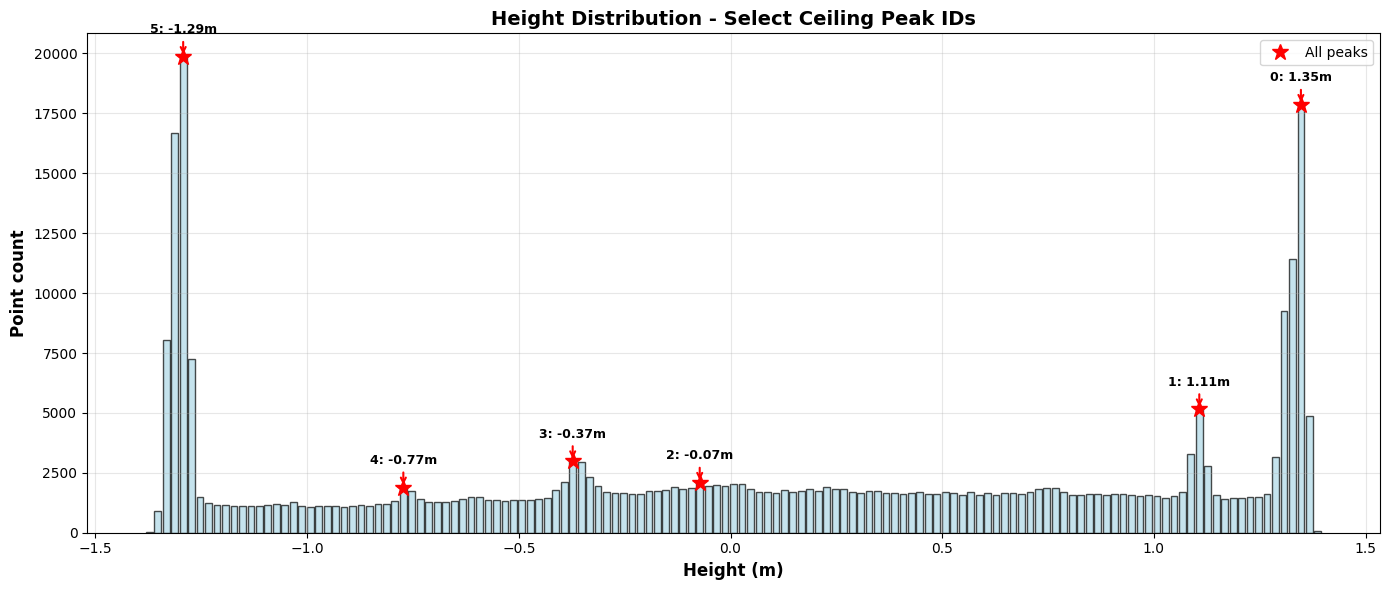


✓ Inspect the plot and choose ceiling peak IDs
  Example: If peaks 0 and 1 are ceilings, use: [0, 1]


In [13]:
step1_result = step1_detect_ceiling_peaks(points, show_top_n=10)

In [14]:
def step2_extract_ceiling_levels(step1_result, selected_peak_ids, thickness=0.10):
    """
    STEP 2: Extract ceiling points for selected peak IDs
    
    Parameters:
    -----------
    step1_result : dict
        Output from step1_detect_ceiling_peaks
    selected_peak_ids : list of int
        Which peak IDs to use as ceilings (e.g., [0, 1])
    thickness : float
        Thickness around each peak (meters)
    
    Returns:
    --------
    ceiling_levels : list of dict
        Each dict contains:
        - 'height': float
        - 'points': np.ndarray (M, 3)
        - 'indices': np.ndarray (M,) - indices into ORIGINAL point cloud
        - 'level_id': int
    """
    
    print(f"\n{'='*70}")
    print(f"STEP 2: EXTRACT CEILING LEVELS")
    print(f"{'='*70}")
    
    peak_heights = step1_result['peak_heights']
    sorted_indices = step1_result['sorted_indices']
    z_coords = step1_result['z_coords']
    points = step1_result['points']
    
    ceiling_levels = []
    
    for peak_id in selected_peak_ids:
        if peak_id >= len(sorted_indices):
            print(f"⚠️  Peak ID {peak_id} out of range!")
            continue
        
        idx = sorted_indices[peak_id]
        height = peak_heights[idx]
        
        # Extract points at this height
        mask = np.abs(z_coords - height) < thickness
        level_points = points[mask]
        level_indices = np.where(mask)[0]  # track indices
        
        ceiling_levels.append({
            'height': height,
            'points': level_points,
            'indices': level_indices, 
            'level_id': peak_id
        })
        
        print(f"✓ Ceiling level {peak_id}: {height:.3f}m with {len(level_points):,} points")
    
    # Visualize (unchanged)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(ceiling_levels)))
    
    # Top view
    for i, level in enumerate(ceiling_levels):
        pts = level['points']
        ax1.scatter(pts[:, 0], pts[:, 1], c=[colors[i]], s=1, alpha=0.7,
                   label=f"Level {level['level_id']} ({level['height']:.2f}m)")
    
    ax1.set_aspect('equal')
    ax1.set_xlabel('X (m)', fontsize=12)
    ax1.set_ylabel('Y (m)', fontsize=12)
    ax1.set_title('Ceiling Levels (Top View)', fontsize=14, fontweight='bold')
    ax1.legend(markerscale=5)
    ax1.grid(True, alpha=0.3)
    
    # 3D view
    ax2 = plt.subplot(122, projection='3d')
    for i, level in enumerate(ceiling_levels):
        pts = level['points']
        if len(pts) > 10000:
            vis_indices = np.random.choice(len(pts), 10000, replace=False)
            pts = pts[vis_indices]
        ax2.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                   c=[colors[i]], s=1, alpha=0.6)
    
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_title('Ceiling Levels (3D)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Extracted {len(ceiling_levels)} ceiling level(s)")
    
    return ceiling_levels


STEP 2: EXTRACT CEILING LEVELS
✓ Ceiling level 0: 1.347m with 48,665 points
✓ Ceiling level 1: 1.107m with 21,829 points


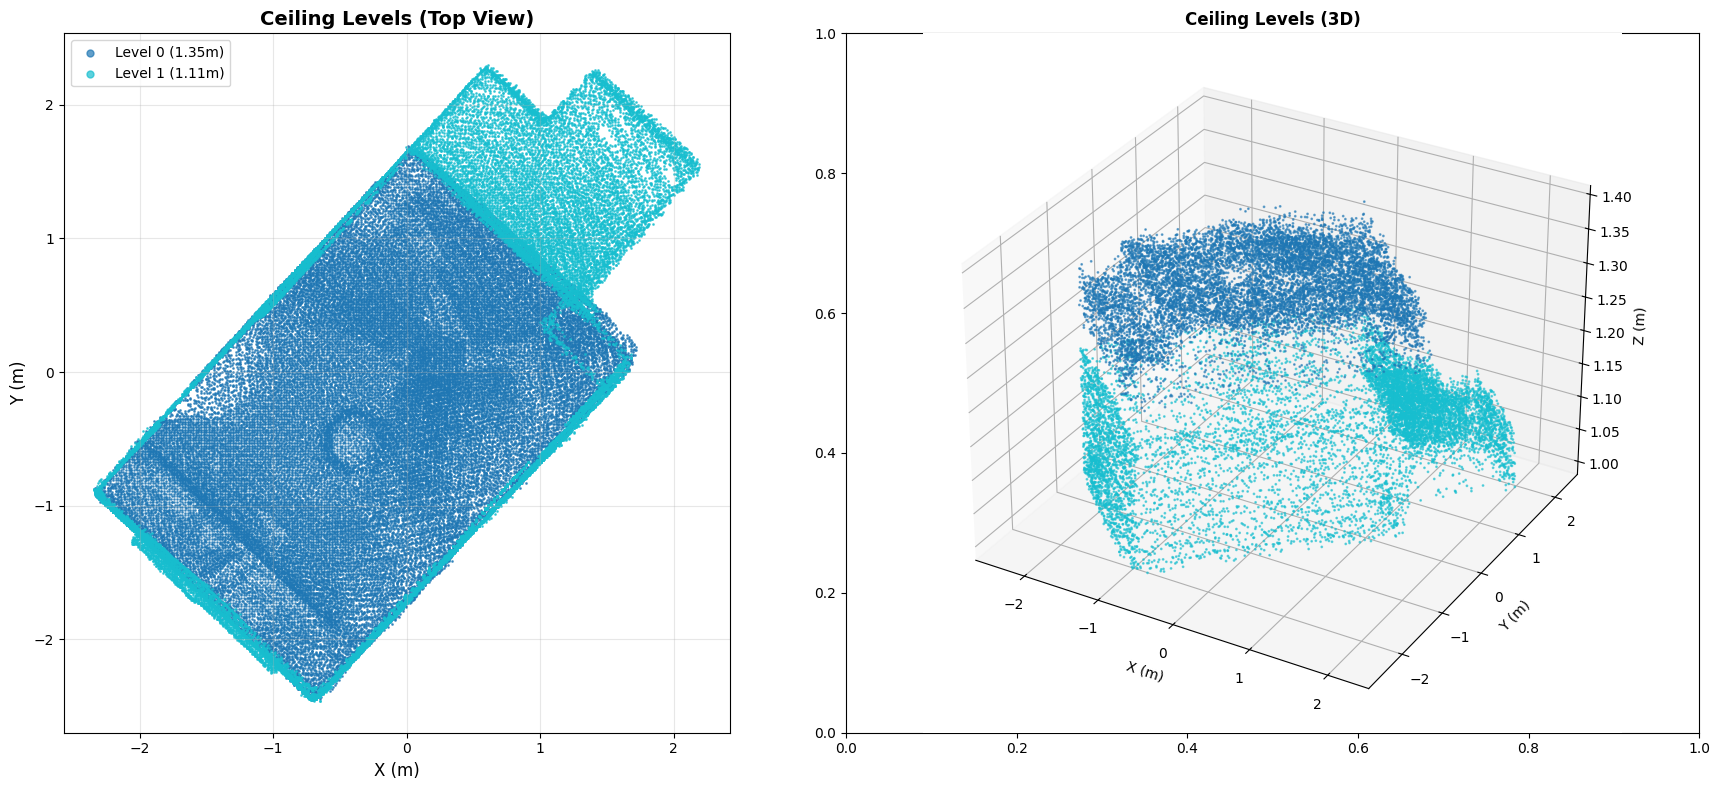


✓ Extracted 2 ceiling level(s)


In [15]:
ceiling_levels = step2_extract_ceiling_levels(
    step1_result,
    selected_peak_ids=[0, 1],
    thickness=0.10
)

In [16]:
all_ceiling_points = np.vstack([i["points"] for i in ceiling_levels])

In [17]:
ceiling_points_2d = all_ceiling_points[:, :2]

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_85521/114049448.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


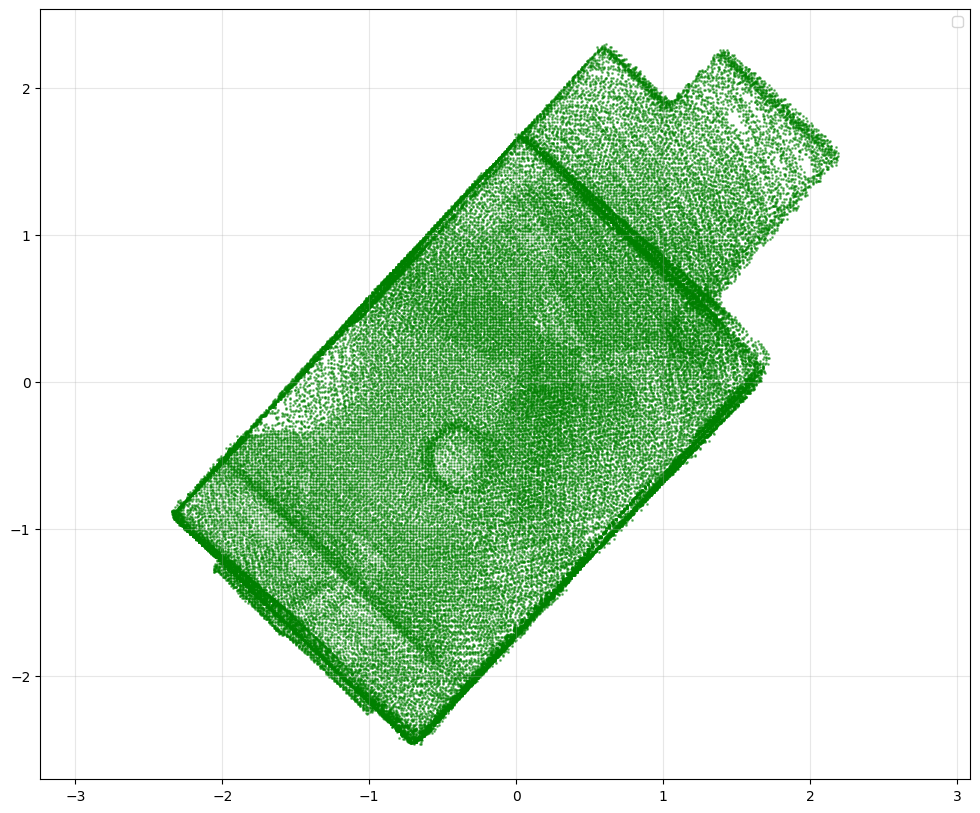

In [18]:
plt.figure(figsize=(12, 10))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1,  alpha=0.5)
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

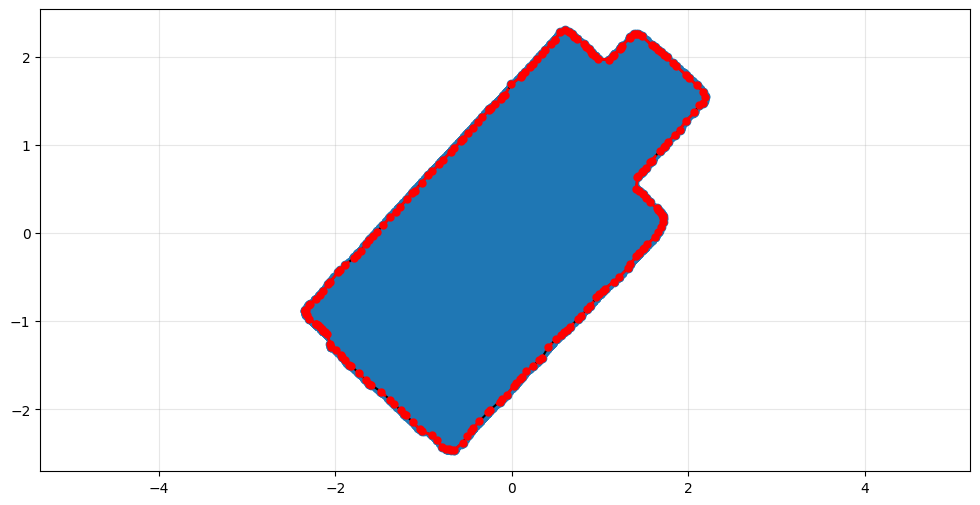

In [28]:
## concave hull with shapely
multi_point = MultiPoint(ceiling_points_2d)
concave = shapely.concave_hull(multi_point, ratio=0.05)

plt.figure(figsize=(12, 6))
plt.plot(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], 'o')

if concave.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = concave.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# recomended tolernce to DP simplicity
room_size = max(ceiling_points_2d[:, 0].max() - ceiling_points_2d[:, 0].min(),
                ceiling_points_2d[:, 1].max() - ceiling_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size

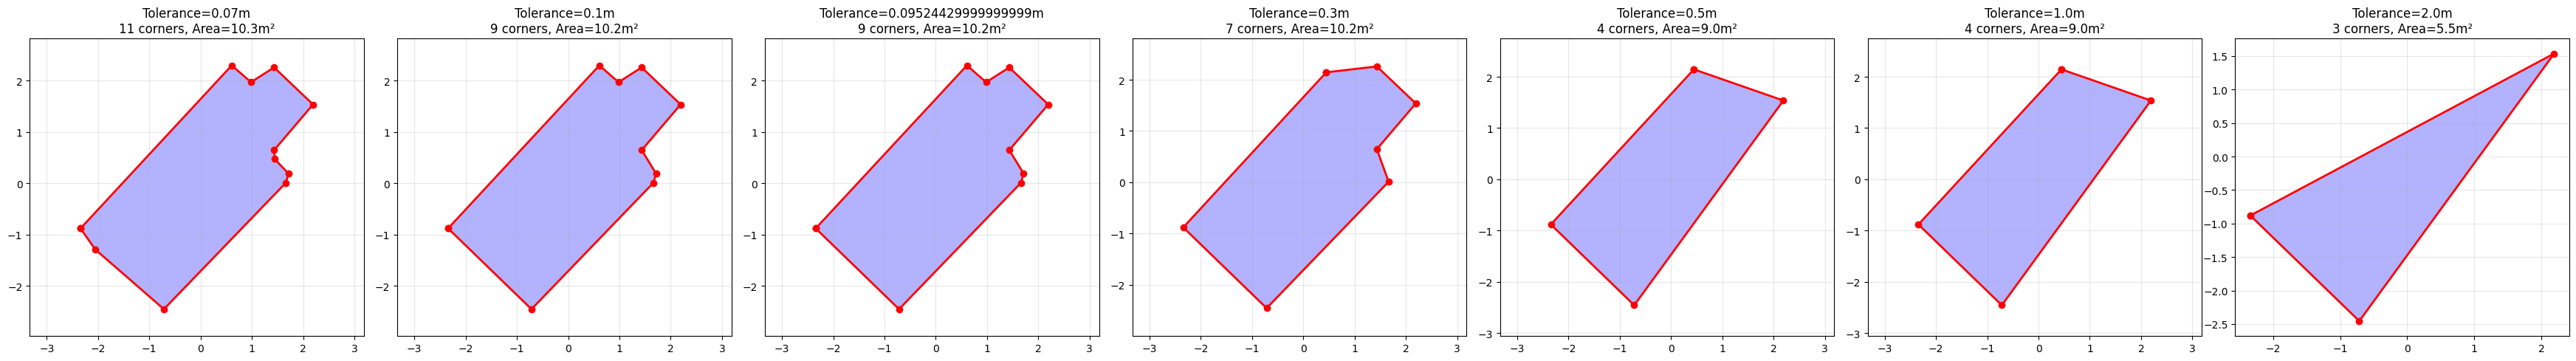

In [36]:
tolerances = [0.07, 0.1, recommended_tolerance, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(tolerances), figsize=(5*len(tolerances), 5))

for idx, tolerance in enumerate(tolerances):
    ax = axes[idx]
    
    # mimplify
    simplified = concave.simplify(tolerance, preserve_topology=True)
    
    x, y = simplified.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified.exterior.coords) - 1
    area = simplified.area
    
    ax.set_title(f'Tolerance={tolerance}m\n{corners} corners, Area={area:.1f}m²')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
def ransac_refine_ceiling_level(ceiling_points, ceiling_indices, 
                                 distance_threshold=0.02,
                                 ransac_n=3, num_iterations=1000):
    """
    RANSAC plane fitting with index tracking
    
    Parameters:
    -----------
    ceiling_points : np.ndarray (N, 3)
        Points from one ceiling level
    ceiling_indices : np.ndarray (N,)
        Indices of these points in ORIGINAL point cloud
    distance_threshold : float
        RANSAC inlier threshold (meters)
    ransac_n : int
        Minimum points to fit plane
    num_iterations : int
        RANSAC iterations
    
    Returns:
    --------
    inlier_points : np.ndarray (M, 3)
        Clean ceiling points (outliers removed)
    inlier_indices : np.ndarray (M,)
        Indices of inliers in ORIGINAL point cloud
    plane_model : tuple (a, b, c, d)
        Plane equation: ax + by + cz + d = 0
    inlier_ratio : float
        Percentage of points kept
    """
    
    print(f"\n{'='*70}")
    print(f"RANSAC PLANE REFINEMENT")
    print(f"{'='*70}")
    print(f"Input points: {len(ceiling_points):,}")
    print(f"Distance threshold: {distance_threshold}m")
    
    # Convert to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ceiling_points)
    
    # RANSAC plane fitting
    plane_model, inlier_mask = pcd.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )
    
    [a, b, c, d] = plane_model
    
    # Extract inliers AND their original indices
    inlier_points = ceiling_points[inlier_mask]
    inlier_indices = ceiling_indices[inlier_mask]  # ← Track through RANSAC!
    
    inlier_ratio = len(inlier_mask) / len(ceiling_points)
    
    print(f"\n✓ Plane equation: {a:.4f}x + {b:.4f}y + {c:.4f}z + {d:.4f} = 0")
    print(f"✓ Inliers: {len(inlier_mask):,} / {len(ceiling_points):,} ({inlier_ratio*100:.1f}%)")
    print(f"✓ Outliers removed: {len(ceiling_points) - len(inlier_mask):,} ({(1-inlier_ratio)*100:.1f}%)")
    
    # Check if plane is roughly horizontal
    normal_z = abs(c)
    if normal_z < 0.9:
        print(f"⚠️  WARNING: Plane is not horizontal! Normal Z: {normal_z:.3f}")
        print(f"   Expected ~1.0 for ceiling. Check your data.")
    
    return inlier_points, inlier_indices, plane_model, inlier_ratio

In [20]:
def refine_all_ceiling_levels(ceiling_levels, distance_threshold=0.02):
    """
    Apply RANSAC to all ceiling levels with index tracking
    
    Parameters:
    -----------
    ceiling_levels : list of dict
        Output from step2_extract_ceiling_levels
    distance_threshold : float
        RANSAC threshold
    
    Returns:
    --------
    refined_levels : list of dict
        Each dict contains:
        - 'height': float
        - 'points': np.ndarray (M, 3) - clean points
        - 'indices': np.ndarray (M,) - original indices
        - 'level_id': int
        - 'plane_equation': tuple
        - 'inlier_ratio': float
        - 'original_count': int
        - 'cleaned_count': int
    """
    
    print(f"\n{'='*70}")
    print(f"REFINING ALL CEILING LEVELS")
    print(f"{'='*70}")
    
    refined_levels = []
    
    for i, level in enumerate(ceiling_levels):
        print(f"\n--- Level {i} (Height: {level['height']:.3f}m) ---")
        
        # RANSAC refinement with index tracking
        clean_points, clean_indices, plane, ratio = ransac_refine_ceiling_level(
            level['points'],
            level['indices'],  # ← Pass indices
            distance_threshold=distance_threshold
        )
        
        # Store refined version
        refined_levels.append({
            'height': level['height'],
            'points': clean_points,
            'indices': clean_indices,  # ← Preserve indices!
            'level_id': level['level_id'],
            'plane_equation': plane,
            'inlier_ratio': ratio,
            'original_count': len(level['points']),
            'cleaned_count': len(clean_points)
        })
    
    # Summary
    print(f"\n{'='*70}")
    print(f"REFINEMENT SUMMARY")
    print(f"{'='*70}")
    
    total_original = 0
    total_cleaned = 0
    
    for level in refined_levels:
        removed = level['original_count'] - level['cleaned_count']
        print(f"Level {level['level_id']} @ {level['height']:.2f}m:")
        print(f"  Original: {level['original_count']:,} points")
        print(f"  Cleaned:  {level['cleaned_count']:,} points")
        print(f"  Removed:  {removed:,} ({removed/level['original_count']*100:.1f}%)")
        
        total_original += level['original_count']
        total_cleaned += level['cleaned_count']
    
    print(f"\nTotal across all levels:")
    print(f"  Original: {total_original:,} points")
    print(f"  Cleaned:  {total_cleaned:,} points")
    print(f"  Removed:  {total_original - total_cleaned:,} ({(total_original-total_cleaned)/total_original*100:.1f}%)")
    
    return refined_levels

In [21]:
refined_ceiling_levels = refine_all_ceiling_levels(
    ceiling_levels,
    distance_threshold=0.1
)


REFINING ALL CEILING LEVELS

--- Level 0 (Height: 1.347m) ---

RANSAC PLANE REFINEMENT
Input points: 48,665
Distance threshold: 0.1m

✓ Plane equation: 0.0037x + -0.0029y + 1.0000z + -1.3288 = 0
✓ Inliers: 48,646 / 48,665 (100.0%)
✓ Outliers removed: 19 (0.0%)

--- Level 1 (Height: 1.107m) ---

RANSAC PLANE REFINEMENT
Input points: 21,829
Distance threshold: 0.1m

✓ Plane equation: 0.0058x + 0.0023y + 1.0000z + -1.1122 = 0
✓ Inliers: 20,882 / 21,829 (95.7%)
✓ Outliers removed: 947 (4.3%)

REFINEMENT SUMMARY
Level 0 @ 1.35m:
  Original: 48,665 points
  Cleaned:  48,646 points
  Removed:  19 (0.0%)
Level 1 @ 1.11m:
  Original: 21,829 points
  Cleaned:  20,882 points
  Removed:  947 (4.3%)

Total across all levels:
  Original: 70,494 points
  Cleaned:  69,528 points
  Removed:  966 (1.4%)


In [22]:
all_clean_ceiling_points = np.vstack([
    level['points'] for level in refined_ceiling_levels
])

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_85521/3181797075.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


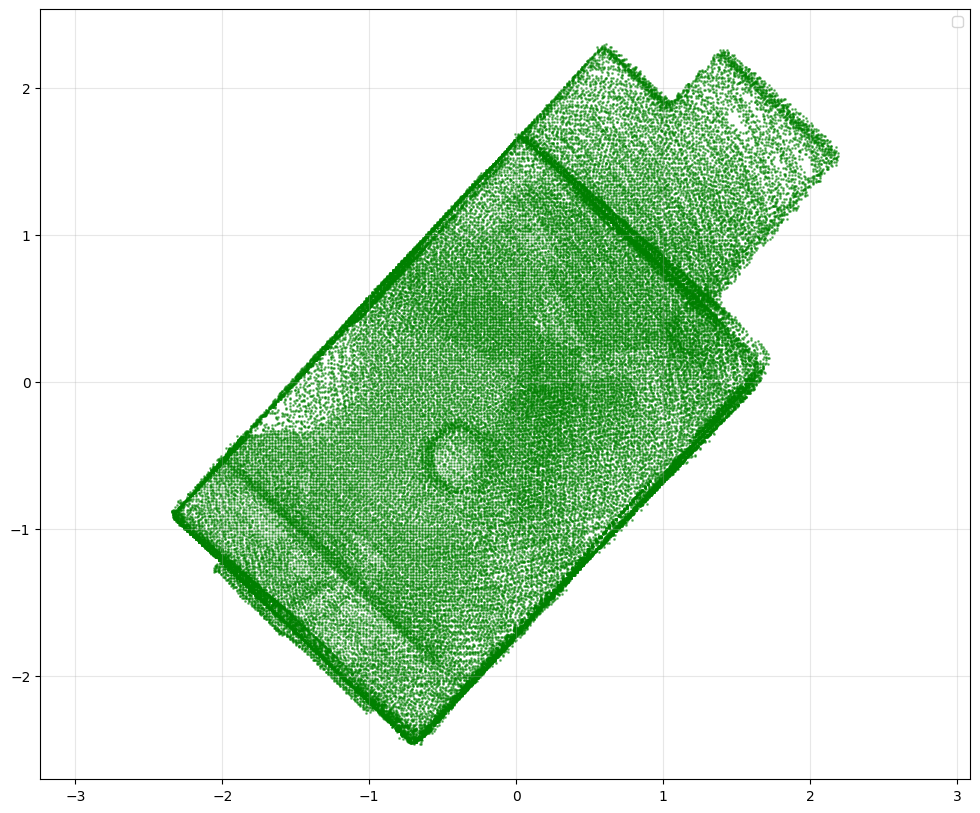

In [23]:
ceiling_points_2d = all_clean_ceiling_points[: , :2]

plt.figure(figsize=(12, 10))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1,  alpha=0.5)
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

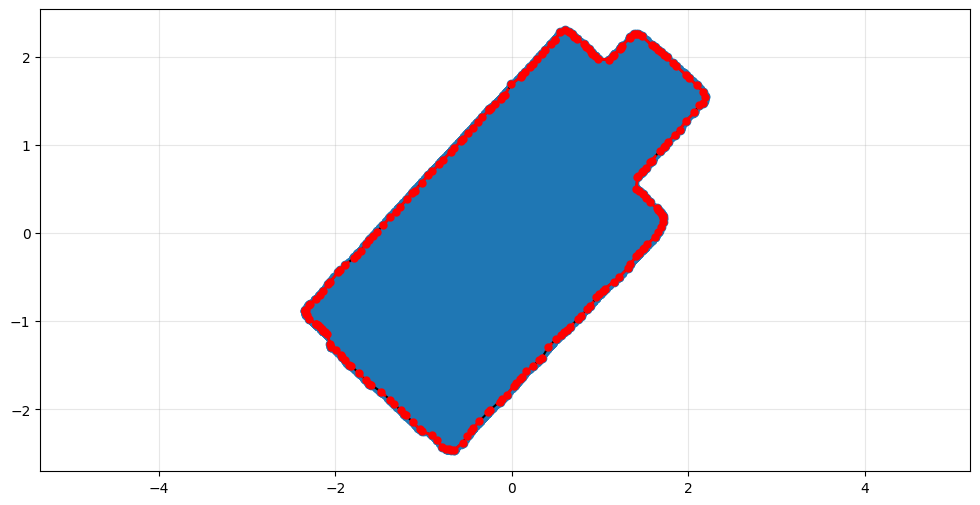

In [29]:
# concave hull with shapely
multi_point = MultiPoint(ceiling_points_2d)
concave = shapely.concave_hull(multi_point, ratio=0.05)

plt.figure(figsize=(12, 6))
plt.plot(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], 'o')

if concave.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = concave.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# tolerance to DP simplicity
room_size = max(ceiling_points_2d[:, 0].max() - ceiling_points_2d[:, 0].min(),
                ceiling_points_2d[:, 1].max() - ceiling_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size

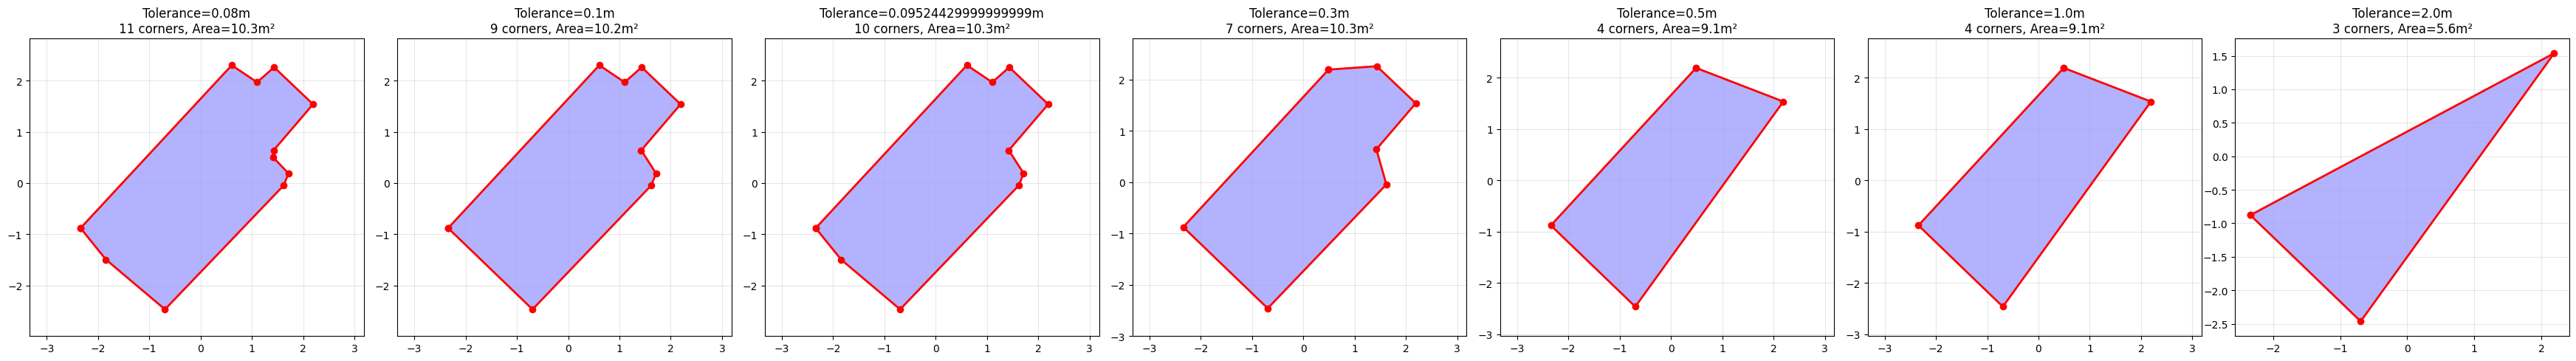

In [31]:
tolerances = [0.08, 0.1, recommended_tolerance, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(tolerances), figsize=(5*len(tolerances), 5))

for idx, tolerance in enumerate(tolerances):
    ax = axes[idx]
    
    # mimplify
    simplified = concave.simplify(tolerance, preserve_topology=True)
    
    x, y = simplified.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified.exterior.coords) - 1
    area = simplified.area
    
    ax.set_title(f'Tolerance={tolerance}m\n{corners} corners, Area={area:.1f}m²')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
def point_to_line_distance(point, line_start, line_end):
    """
    Calculate perpendicular distance from point to line segment
    
    Parameters:
    -----------
    point : np.ndarray (2,)
        Point coordinates [x, y]
    line_start : np.ndarray (2,)
        Line start point [x, y]
    line_end : np.ndarray (2,)
        Line end point [x, y]
    
    Returns:
    --------
    distance : float
        Perpendicular distance in meters
    """
    
    # Vector from line_start to line_end
    line_vec = line_end - line_start
    line_length = np.linalg.norm(line_vec)
    
    if line_length < 1e-10:  # Degenerate line
        return np.linalg.norm(point - line_start)
    
    # Normalized line direction
    line_dir = line_vec / line_length
    
    # Vector from line_start to point
    point_vec = point - line_start
    
    # Project point onto line
    projection_length = np.dot(point_vec, line_dir)
    
    # Perpendicular vector
    perpendicular = point_vec - projection_length * line_dir
    
    return np.linalg.norm(perpendicular)

In [50]:
def fit_line_to_points(points):
    """
    Fit line through points and compute fitting error
    
    Parameters:
    -----------
    points : np.ndarray (N, 2)
        Point coordinates
    
    Returns:
    --------
    line_start : np.ndarray (2,)
        Best fit line start (first point)
    line_end : np.ndarray (2,)
        Best fit line end (last point)
    max_error : float
        Maximum perpendicular distance of any point from line
    """
    
    if len(points) < 2:
        return points[0], points[0], 0.0
    
    # Simple approach: line from first to last point
    line_start = points[0]
    line_end = points[-1]
    
    # Compute max error
    max_error = 0.0
    for point in points[1:-1]:  # Skip endpoints
        dist = point_to_line_distance(point, line_start, line_end)
        max_error = max(max_error, dist)
    
    return line_start, line_end, max_error

In [134]:
def detect_wall_segments(polygon_points, tolerance=0.02, min_segment_length=0.10):
    """
    Detect straight wall segments from concave hull polygon
    
    Uses iterative collinearity checking: adds points to current segment
    while they remain within tolerance of fitted line.
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Ordered polygon vertices from concave hull (closed: first=last)
    tolerance : float
        Maximum perpendicular distance from fitted line (meters)
        Default: 0.02m (2cm) for high accuracy
    min_segment_length : float
        Minimum wall length to keep (meters)
        Default: 0.10m (filter out tiny segments)
    
    Returns:
    --------
    segments : list of dict
        Each segment contains:
        - 'start': np.ndarray (2,) - segment start point
        - 'end': np.ndarray (2,) - segment end point
        - 'length': float - wall length in meters
        - 'angle': float - wall orientation (0-360 degrees from +X axis)
        - 'point_indices': np.ndarray - which polygon points belong to segment
        - 'num_points': int - how many points in this segment
        - 'max_deviation': float - maximum deviation from line
    """
    
    print(f"\n{'='*70}")
    print(f"WALL SEGMENT DETECTION")
    print(f"{'='*70}")
    print(f"Input polygon: {len(polygon_points)} vertices")
    print(f"Tolerance: {tolerance}m ({tolerance*100:.1f}cm)")
    print(f"Min segment length: {min_segment_length}m")
    
    # Remove duplicate last point if polygon is closed
    if np.allclose(polygon_points[0], polygon_points[-1]):
        polygon_points = polygon_points[:-1]
        print(f"Removed duplicate closing vertex → {len(polygon_points)} vertices")
    
    n_points = len(polygon_points)
    segments = []
    
    i = 0  # Current starting point
    
    while i < n_points:
        # Start new segment at point i
        segment_start_idx = i
        segment_indices = [i]
        
        # Try to extend segment by adding more points
        j = i + 1
        
        while j < n_points:
            # Get current segment points (from i to j inclusive)
            current_indices = list(range(i, j + 1))
            current_points = polygon_points[current_indices]
            
            # Fit line and check error
            line_start, line_end, max_error = fit_line_to_points(current_points)
            
            if max_error <= tolerance:
                # Point j fits the line, add it to segment
                segment_indices = current_indices
                j += 1
            else:
                # Point j doesn't fit, stop extending
                break
        
        # Also check wrap-around for last segment
        if i == 0:
            # Try extending backwards from end of polygon
            j = n_points - 1
            while j > segment_indices[-1]:
                # Check if wrapping around maintains collinearity
                wrap_indices = list(range(i, segment_indices[-1] + 1)) + [j]
                wrap_points = polygon_points[wrap_indices]
                
                line_start, line_end, max_error = fit_line_to_points(wrap_points)
                
                if max_error <= tolerance:
                    segment_indices = wrap_indices
                    j -= 1
                else:
                    break
        
        # Finalize segment
        if len(segment_indices) >= 2:
            seg_points = polygon_points[segment_indices]
            seg_start = seg_points[0]
            seg_end = seg_points[-1]
            seg_length = np.linalg.norm(seg_end - seg_start)
            
            # Compute angle (from +X axis, counter-clockwise)
            dx = seg_end[0] - seg_start[0]
            dy = seg_end[1] - seg_start[1]
            angle_rad = np.arctan2(dy, dx)
            angle_deg = np.degrees(angle_rad) % 360
            
            # Compute max deviation
            _, _, max_deviation = fit_line_to_points(seg_points)
            
            # Only keep if long enough
            if seg_length >= min_segment_length:
                segments.append({
                    'start': seg_start,
                    'end': seg_end,
                    'length': seg_length,
                    'angle': angle_deg,
                    'point_indices': np.array(segment_indices),
                    'num_points': len(segment_indices),
                    'max_deviation': max_deviation
                })
        
        # Move to next segment
        i = segment_indices[-1] + 1
    
    # Summary
    print(f"\n{'='*70}")
    print(f"DETECTED SEGMENTS")
    print(f"{'='*70}")
    print(f"Total segments: {len(segments)}")
    print(f"\n{'Seg':<5} {'Length':<10} {'Angle':<10} {'Points':<10} {'Max Dev':<10}")
    print(f"{'─'*50}")
    
    total_length = 0.0
    for i, seg in enumerate(segments, 1):
        print(f"{i:<5} {seg['length']:<10.3f} {seg['angle']:<10.1f} "
              f"{seg['num_points']:<10} {seg['max_deviation']:<10.4f}")
        total_length += seg['length']
    
    print(f"\n✓ Total perimeter (sum of segments): {total_length:.3f}m")
    
    # Compute area from original polygon
    polygon_closed = np.vstack([polygon_points, polygon_points[0]])
    area = compute_polygon_area(polygon_closed)
    print(f"✓ Polygon area: {area:.3f}m²")
    
    return segments

In [135]:
def compute_polygon_area(polygon_points):
    """
    Compute area of polygon using shoelace formula
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Closed polygon (first point = last point)
    
    Returns:
    --------
    area : float
        Polygon area in m²
    """
    
    x = polygon_points[:, 0]
    y = polygon_points[:, 1]
    
    # Shoelace formula
    area = 0.5 * np.abs(np.dot(x[:-1], y[1:]) - np.dot(x[1:], y[:-1]))
    
    return area

In [136]:
def merge_collinear_segments(segments, angle_tolerance=2.0, gap_tolerance=0.05):
    """
    Merge adjacent segments that are collinear (on same line)
    
    Sometimes the detector splits one wall into multiple segments.
    This function merges them back together.
    
    Parameters:
    -----------
    segments : list of dict
        Detected segments
    angle_tolerance : float
        Maximum angle difference to consider collinear (degrees)
    gap_tolerance : float
        Maximum gap between segments to merge (meters)
    
    Returns:
    --------
    merged_segments : list of dict
        Merged segments
    """
    
    if len(segments) < 2:
        return segments
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR SEGMENTS")
    print(f"{'='*70}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Gap tolerance: {gap_tolerance}m")
    
    merged = []
    i = 0
    
    while i < len(segments):
        current = segments[i]
        
        # Try to merge with next segment
        while i + 1 < len(segments):
            next_seg = segments[i + 1]
            
            # Check if angles are similar
            angle_diff = abs(current['angle'] - next_seg['angle'])
            angle_diff = min(angle_diff, 360 - angle_diff)  # Handle wraparound
            
            # Check if endpoints are close
            gap = np.linalg.norm(current['end'] - next_seg['start'])
            
            # Check collinearity: is next segment on same line?
            dist = point_to_line_distance(next_seg['end'], current['start'], current['end'])
            
            if angle_diff <= angle_tolerance and gap <= gap_tolerance and dist <= 0.03:
                # Merge segments
                print(f"  Merging segment {i+1} and {i+2}")
                current = {
                    'start': current['start'],
                    'end': next_seg['end'],
                    'length': np.linalg.norm(next_seg['end'] - current['start']),
                    'angle': current['angle'],  # Keep first angle
                    'point_indices': np.concatenate([current['point_indices'], 
                                                     next_seg['point_indices']]),
                    'num_points': current['num_points'] + next_seg['num_points'],
                    'max_deviation': max(current['max_deviation'], next_seg['max_deviation'])
                }
                i += 1  # Skip next segment
            else:
                break
        
        merged.append(current)
        i += 1
    
    print(f"\n✓ Reduced from {len(segments)} to {len(merged)} segments")
    
    return merged

In [137]:
def visualize_wall_segments(polygon_points, segments, figsize=(14, 12)):
    """
    Visualize detected wall segments with labels
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Original polygon vertices
    segments : list of dict
        Detected segments
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot polygon
    poly_closed = np.vstack([polygon_points, polygon_points[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1], 'o-', 
            color='red', markersize=3, linewidth=1, alpha=0.5, 
            label='Concave hull vertices')
    
    # Plot detected segments
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))
    
    for i, seg in enumerate(segments):
        color = colors[i]
        
        # Draw segment line
        ax.plot([seg['start'][0], seg['end'][0]], 
                [seg['start'][1], seg['end'][1]], 
                '-', color=color, linewidth=3, alpha=0.8)
        
        # Draw arrow in middle showing direction
        mid_x = (seg['start'][0] + seg['end'][0]) / 2
        mid_y = (seg['start'][1] + seg['end'][1]) / 2
        
        dx = seg['end'][0] - seg['start'][0]
        dy = seg['end'][1] - seg['start'][1]
        length = seg['length']
        
        # Small arrow
        arrow_scale = 0.1
        ax.arrow(mid_x - dx*arrow_scale/2, mid_y - dy*arrow_scale/2,
                dx*arrow_scale, dy*arrow_scale,
                head_width=0.1, head_length=0.05, 
                fc=color, ec=color, alpha=0.7)
        
        # Label with segment number and length
        label_offset = 0.2
        # Perpendicular offset for label
        perp_x = -dy / length * label_offset
        perp_y = dx / length * label_offset
        
        ax.text(mid_x + perp_x, mid_y + perp_y, 
                f"{i+1}: {seg['length']:.2f}m\n{seg['angle']:.0f}°",
                fontsize=9, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor=color, alpha=0.7, edgecolor='black'))
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
    ax.set_title(f'Detected Wall Segments ({len(segments)} walls)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    return fig

In [162]:
polygon_points = np.array(concave.exterior.coords)

In [163]:
from simplification.cutil import simplify_coords_vw

In [ ]:
simplified_points = simplify_coords_vw(
    polygon_points,
    epsilon=0.001  
)

In [165]:
print(f"Vertices: {len(polygon_points)} → {len(simplified_points)}")

Vertices: 175 → 64


In [168]:
from simplification.cutil import simplify_coords_vw
import numpy as np

# Step 1: Get concave hull
concave = shapely.concave_hull(multi_point, ratio=0.05)
polygon_points = np.array(concave.exterior.coords)

print(f"Original vertices: {len(polygon_points)}")

# Step 2: Apply Visvalingam-Whyatt
# Try different thresholds to find best balance
for threshold in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
    simplified = simplify_coords_vw(polygon_points, epsilon=threshold)
    
    print(f"\nThreshold: {threshold} m²")
    print(f"  Vertices: {len(polygon_points)} → {len(simplified)}")
    
    # Test 10-point deviation
    if len(simplified) >= 10:
        # from wall_segment_detection import fit_line_to_points
        _, _, err = fit_line_to_points(simplified[0:10])
        print(f"  10-point error: {err*100:.1f}cm")
    
    # Try segment detection
    segments = detect_wall_segments(
        simplified,
        tolerance=0.10,
        min_segment_length=0.20
    )
    
    print(f"  Segments detected: {len(segments)}")
    
    if len(segments) > 4:  # If we get more than 4 walls
        merged = merge_collinear_segments(segments)
        total_perim = sum(seg['length'] for seg in merged)
        print(f"  After merging: {len(merged)} walls")
        print(f"  Total perimeter: {total_perim:.2f}m")
        
        # Visualize
        fig = visualize_wall_segments(simplified, merged)
        plt.title(f'V-W Threshold={threshold} m² ({len(merged)} walls)')
        plt.show()

Original vertices: 175

Threshold: 0.0001 m²
  Vertices: 175 → 121
  10-point error: 17.8cm

WALL SEGMENT DETECTION
Input polygon: 121 vertices
Tolerance: 0.1m (10.0cm)
Min segment length: 0.2m
Removed duplicate closing vertex → 120 vertices

DETECTED SEGMENTS
Total segments: 0

Seg   Length     Angle      Points     Max Dev   
──────────────────────────────────────────────────

✓ Total perimeter (sum of segments): 0.000m
✓ Polygon area: 10.487m²
  Segments detected: 0

Threshold: 0.0005 m²
  Vertices: 175 → 84
  10-point error: 16.6cm

WALL SEGMENT DETECTION
Input polygon: 84 vertices
Tolerance: 0.1m (10.0cm)
Min segment length: 0.2m
Removed duplicate closing vertex → 83 vertices

DETECTED SEGMENTS
Total segments: 1

Seg   Length     Angle      Points     Max Dev   
──────────────────────────────────────────────────
1     0.484      227.4      5          0.0533    

✓ Total perimeter (sum of segments): 0.484m
✓ Polygon area: 10.487m²
  Segments detected: 1

Threshold: 0.001 m²
  Verti

In [169]:
simplified

array([[ 0.447334  ,  2.144724  ],
       [ 0.607524  ,  2.29853   ],
       [ 0.9822075 ,  1.9712985 ],
       [ 1.14893   ,  2.01096   ],
       [ 1.432823  ,  2.259524  ],
       [ 2.172673  ,  1.597364  ],
       [ 2.172458  ,  1.47511   ],
       [ 1.433578  ,  0.646731  ],
       [ 1.4443275 ,  0.4734925 ],
       [ 1.71852   ,  0.167019  ],
       [ 1.619163  , -0.046159  ],
       [ 1.21388   , -0.503198  ],
       [ 0.992304  , -0.691307  ],
       [ 0.341431  , -1.416711  ],
       [-0.368345  , -2.133253  ],
       [-0.652861  , -2.463685  ],
       [-0.794797  , -2.422292  ],
       [-2.05535875, -1.289164  ],
       [-2.341896  , -0.882045  ],
       [-0.946553  ,  0.65489   ],
       [ 0.447334  ,  2.144724  ]])

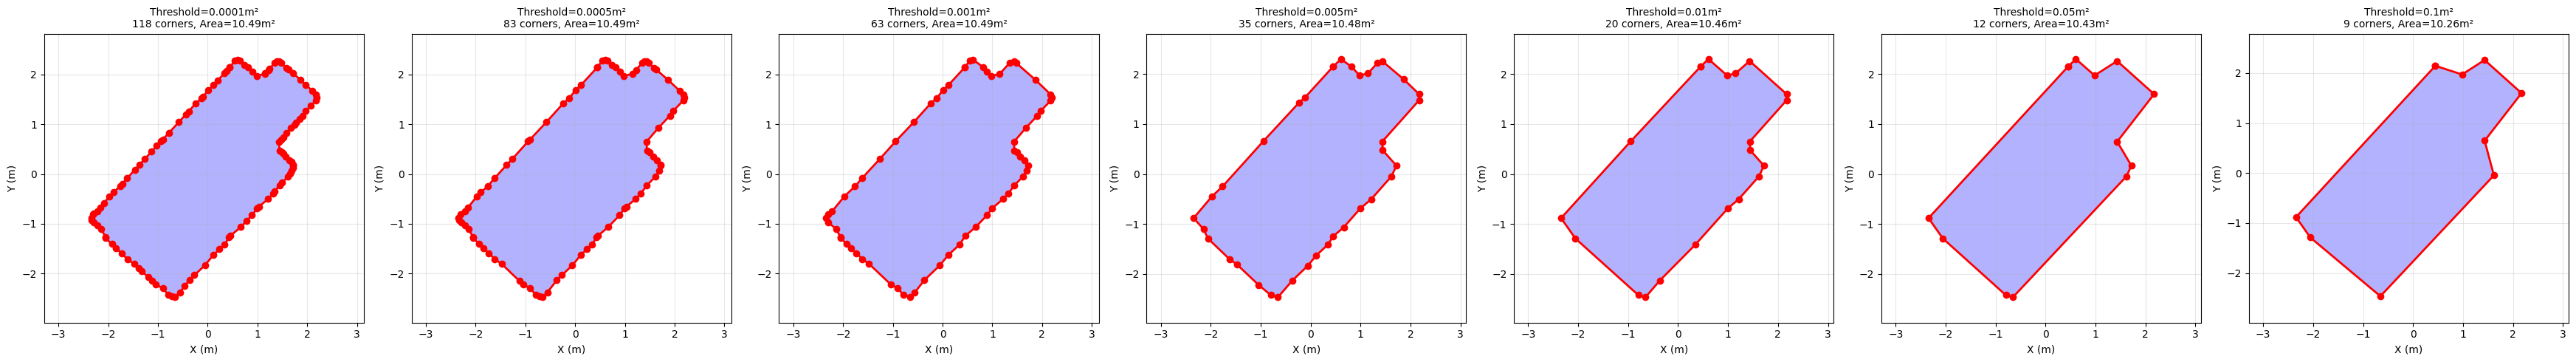


VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON
Threshold (m²)  Vertices   Area (m²) 
----------------------------------------------------------------------
0.0001          118        10.49     
0.0005          83         10.49     
0.0010          63         10.49     
0.0050          35         10.48     
0.0100          20         10.46     
0.0500          12         10.43     
0.1000          9          10.26     


In [41]:
from simplification.cutil import simplify_coords_vw
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Get your concave hull points
polygon_points = np.array(concave.exterior.coords)

# V-W uses "effective area" threshold (m²), not distance
# Smaller threshold = more detail, larger threshold = more simplified
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):
    ax = axes[idx]
    
    # Apply Visvalingam-Whyatt simplification
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    
    # Create polygon for area calculation
    simplified_poly = Polygon(simplified_points)
    
    # Plot
    x, y = simplified_points[:, 0], simplified_points[:, 1]
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified_points) - 1
    area = simplified_poly.area
    
    # # Test 10-point deviation if enough points
    # if len(simplified_points) >= 10:
    #     # from wall_segment_detection import fit_line_to_points
    #     _, _, err = fit_line_to_points(simplified_points[0:10])
    #     error_text = f'\n10-pt err: {err*100:.1f}cm'
    # else:
    #     error_text = ''
    
    ax.set_title(f'Threshold={threshold}m²\n{corners} corners, Area={area:.2f}m²',
                fontsize=10)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

# Also print summary
print("\n" + "="*70)
print("VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON")
print("="*70)
print(f"{'Threshold (m²)':<15} {'Vertices':<10} {'Area (m²)':<10}")
print("-"*70)

for threshold in thresholds:
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    poly = Polygon(simplified_points)
    
    
    print(f"{threshold:<15.4f} {len(simplified_points)-1:<10} {poly.area:<10.2f}")

In [106]:
def straighten_polyline(points, 
                       straightness_threshold=175.0,  # Degrees
                       max_deviation=0.08):            # Meters
    """
    Detect nearly-straight sequences and replace with actual straight lines
    
    This is DIFFERENT from simplification!
    
    Example:
    Input:  [P1, P2, P3, P4, P5, P6] (6 points, slightly wavy)
            P1─P2
               ╲P3
                ╲P4
                 P5─P6
    
    If P1...P4 are nearly collinear (angles ~178-180°):
    Output: [P1, P4, P5, P6] (4 points, P1-P4 is now perfectly straight)
    
    This PRESERVES the wall length (P1 to P4 distance)
    But REMOVES the waviness
    """
    
    straightened = []
    i = 0
    
    while i < len(points):
        # Start new segment
        segment_start = i
        straightened.append(points[i])
        
        # Try to extend segment while points remain nearly collinear
        j = i + 1
        
        while j < len(points) - 1:
            # Check if points [i...j+1] are nearly collinear
            
            # Method 1: Check angles
            # If angle at each point ≈ 180°, they're on same line
            
            # Method 2: Check deviation from line
            # Fit line through [i...j+1]
            # If max deviation < threshold, they're straight
            
            segment_points = points[i:j+2]
            line_start, line_end, max_dev = fit_line_to_points(segment_points)
            
            # Also check angles
            angles_ok = check_angles_nearly_straight(segment_points, straightness_threshold)
            
            if max_dev <= max_deviation and angles_ok:
                # Still straight, continue extending
                j += 1
            else:
                # No longer straight, finalize segment
                break
        
        # Finalize: Use endpoint of straight segment
        if j > i + 1:  # If we found a straight sequence
            straightened.append(points[j])
            i = j
        else:
            i += 1
    
    return np.array(straightened)

In [107]:
def check_angles_nearly_straight(points, threshold_deg=175.0):
    """
    Check if all angles in sequence are nearly 180° (straight)
    """
    if len(points) < 3:
        return True
    
    for i in range(1, len(points) - 1):
        v1 = points[i] - points[i-1]
        v2 = points[i+1] - points[i]
        
        # Compute angle
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle_deg = np.degrees(np.arccos(cos_angle))
        
        # Check if nearly straight (180° = collinear)
        if angle_deg < threshold_deg:
            return False
    
    return True


def straighten_and_simplify(polygon_points,
                            straighten_deviation=0.08,
                            straightness_angle=175.0,
                            vw_threshold=0.001):
    """
    TWO-STAGE pipeline following IEEE paper
    
    Stage 1: Straighten (normalize polylines)
    Stage 2: Simplify (remove redundant vertices with V-W)
    """
    
    print(f"\n{'='*70}")
    print(f"TWO-STAGE POLYLINE PROCESSING")
    print(f"{'='*70}")
    
    print(f"\nOriginal: {len(polygon_points)} vertices")
    
    # STAGE 1: STRAIGHTEN
    print(f"\nStage 1: Straightening...")
    print(f"  Max deviation: {straighten_deviation}m")
    print(f"  Angle threshold: {straightness_angle}°")
    
    straightened = straighten_polyline_iterative(
        polygon_points,
        max_deviation=straighten_deviation,
        angle_threshold=straightness_angle
    )
    
    print(f"  After straightening: {len(straightened)} vertices")
    
    # STAGE 2: SIMPLIFY with V-W
    print(f"\nStage 2: Simplifying (V-W)...")
    print(f"  Threshold: {vw_threshold}m²")
    
    from simplification.cutil import simplify_coords_vw
    simplified = simplify_coords_vw(straightened, epsilon=vw_threshold)
    
    print(f"  After V-W: {len(simplified)} vertices")
    
    return simplified


def straighten_polyline_iterative(points, max_deviation=0.08, angle_threshold=175.0):
    """
    Straighten nearly-straight sequences iteratively
    """
    
    straightened = [points[0]]
    i = 0
    
    while i < len(points) - 1:
        # Try to extend from current point
        j = i + 1
        best_j = i + 1
        
        # Greedy: extend as far as possible while remaining straight
        while j < len(points):
            segment = points[i:j+1]
            
            # Check straightness
            if len(segment) >= 3:
                line_start, line_end, max_dev = fit_line_to_points(segment)
                angles_ok = check_angles_nearly_straight(segment, angle_threshold)
                
                if max_dev <= max_deviation and angles_ok:
                    best_j = j
                    j += 1
                else:
                    break
            else:
                best_j = j
                j += 1
        
        # Add endpoint of straight segment
        if best_j > i + 1:
            # Found a straight sequence, use its endpoint
            straightened.append(points[best_j])
            i = best_j
        else:
            # No straight sequence, just add next point
            straightened.append(points[i + 1])
            i += 1
    
    return np.array(straightened)

In [108]:
def detect_corners(polygon_points, min_angle_change=20.0):
    """
    Detect real corners (significant direction changes)
    
    Not every vertex is a corner!
    Corner = angle change > threshold (e.g., 20-30 degrees)
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Simplified polygon vertices
    min_angle_change : float
        Minimum angle change to be considered a corner (degrees)
    
    Returns:
    --------
    corners : list of dict
        Each corner:
        - 'index': int - vertex index
        - 'position': np.ndarray (2,) - (x, y)
        - 'angle': float - interior angle at corner
    """
    
    print(f"\n{'='*70}")
    print(f"CORNER DETECTION")
    print(f"{'='*70}")
    print(f"Min angle change: {min_angle_change}°")
    
    corners = []
    n = len(polygon_points)
    
    for i in range(n):
        # Get three consecutive points
        prev_idx = (i - 1) % n
        curr_idx = i
        next_idx = (i + 1) % n
        
        p_prev = polygon_points[prev_idx]
        p_curr = polygon_points[curr_idx]
        p_next = polygon_points[next_idx]
        
        # Vectors
        v1 = p_prev - p_curr
        v2 = p_next - p_curr
        
        # Angle between vectors
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        # Interior angle
        interior_angle = 180 - angle_deg
        
        # Check if significant angle change (corner)
        if abs(angle_deg) > min_angle_change:
            corners.append({
                'index': curr_idx,
                'position': p_curr.copy(),
                'angle': interior_angle
            })
    
    print(f"\n✓ Detected {len(corners)} corners")
    
    for i, corner in enumerate(corners):
        print(f"  Corner {i+1}: ({corner['position'][0]:.2f}, {corner['position'][1]:.2f}) "
              f"@ {corner['angle']:.1f}°")
    
    return corners


def compute_wall_dimensions_from_corners(corners):
    """
    Compute wall lengths between consecutive corners
    
    This gives you the actual room dimensions!
    
    Returns:
    --------
    walls : list of dict
        Each wall:
        - 'start_corner': int
        - 'end_corner': int
        - 'length': float (meters)
        - 'angle': float (orientation in degrees)
    """
    
    print(f"\n{'='*70}")
    print(f"WALL DIMENSIONS (Corner-to-Corner)")
    print(f"{'='*70}")
    
    walls = []
    n_corners = len(corners)
    
    for i in range(n_corners):
        start_corner = corners[i]
        end_corner = corners[(i + 1) % n_corners]
        
        # Vector from start to end
        vec = end_corner['position'] - start_corner['position']
        length = np.linalg.norm(vec)
        
        # Angle
        angle_rad = np.arctan2(vec[1], vec[0])
        angle_deg = np.degrees(angle_rad) % 360
        
        walls.append({
            'start_corner': i,
            'end_corner': (i + 1) % n_corners,
            'length': length,
            'angle': angle_deg,
            'start_pos': start_corner['position'],
            'end_pos': end_corner['position']
        })
        
        print(f"Wall {i+1}: {length:.3f}m @ {angle_deg:.1f}° "
              f"(Corner {i+1} → Corner {(i+1)%n_corners + 1})")
    
    total_perimeter = sum(wall['length'] for wall in walls)
    print(f"\n✓ Total perimeter: {total_perimeter:.3f}m")
    
    return walls

In [53]:
polygon_points = np.array(concave.exterior.coords)
straightened_simplified = straighten_and_simplify(
    polygon_points,
    straighten_deviation=0.08,
    straightness_angle=170.0,
    vw_threshold=0.05
)


TWO-STAGE POLYLINE PROCESSING

Original: 173 vertices

Stage 1: Straightening...
  Max deviation: 0.08m
  Angle threshold: 170.0°
  After straightening: 173 vertices

Stage 2: Simplifying (V-W)...
  Threshold: 0.05m²
  After V-W: 13 vertices


In [54]:
polygon_points = straightened_simplified

In [55]:
corners = detect_corners(
    polygon_points,
    min_angle_change=45.0 
)


CORNER DETECTION
Min angle change: 45.0°

✓ Detected 13 corners
  Corner 1: (0.45, 2.14) @ 90.0°
  Corner 2: (0.61, 2.30) @ 85.0°
  Corner 3: (0.98, 1.97) @ 73.7°
  Corner 4: (1.43, 2.26) @ 74.4°
  Corner 5: (2.17, 1.60) @ 86.0°
  Corner 6: (1.43, 0.65) @ 68.6°
  Corner 7: (1.72, 0.17) @ 55.7°
  Corner 8: (1.62, -0.05) @ 18.2°
  Corner 9: (-0.65, -2.46) @ 63.0°
  Corner 10: (-0.79, -2.42) @ 25.7°
  Corner 11: (-2.06, -1.29) @ 12.9°
  Corner 12: (-2.34, -0.88) @ 77.8°
  Corner 13: (0.45, 2.14) @ 90.0°


In [56]:
walls = compute_wall_dimensions_from_corners(corners)


WALL DIMENSIONS (Corner-to-Corner)
Wall 1: 0.222m @ 43.8° (Corner 1 → Corner 2)
Wall 2: 0.497m @ 318.9° (Corner 2 → Corner 3)
Wall 3: 0.535m @ 32.6° (Corner 3 → Corner 4)
Wall 4: 0.993m @ 318.2° (Corner 4 → Corner 5)
Wall 5: 1.204m @ 232.1° (Corner 5 → Corner 6)
Wall 6: 0.558m @ 300.7° (Corner 6 → Corner 7)
Wall 7: 0.235m @ 245.0° (Corner 7 → Corner 8)
Wall 8: 3.318m @ 226.8° (Corner 8 → Corner 9)
Wall 9: 0.148m @ 163.7° (Corner 9 → Corner 10)
Wall 10: 1.695m @ 138.0° (Corner 10 → Corner 11)
Wall 11: 0.498m @ 125.1° (Corner 11 → Corner 12)
Wall 12: 4.116m @ 47.3° (Corner 12 → Corner 13)
Wall 13: 0.000m @ 0.0° (Corner 13 → Corner 1)

✓ Total perimeter: 14.019m


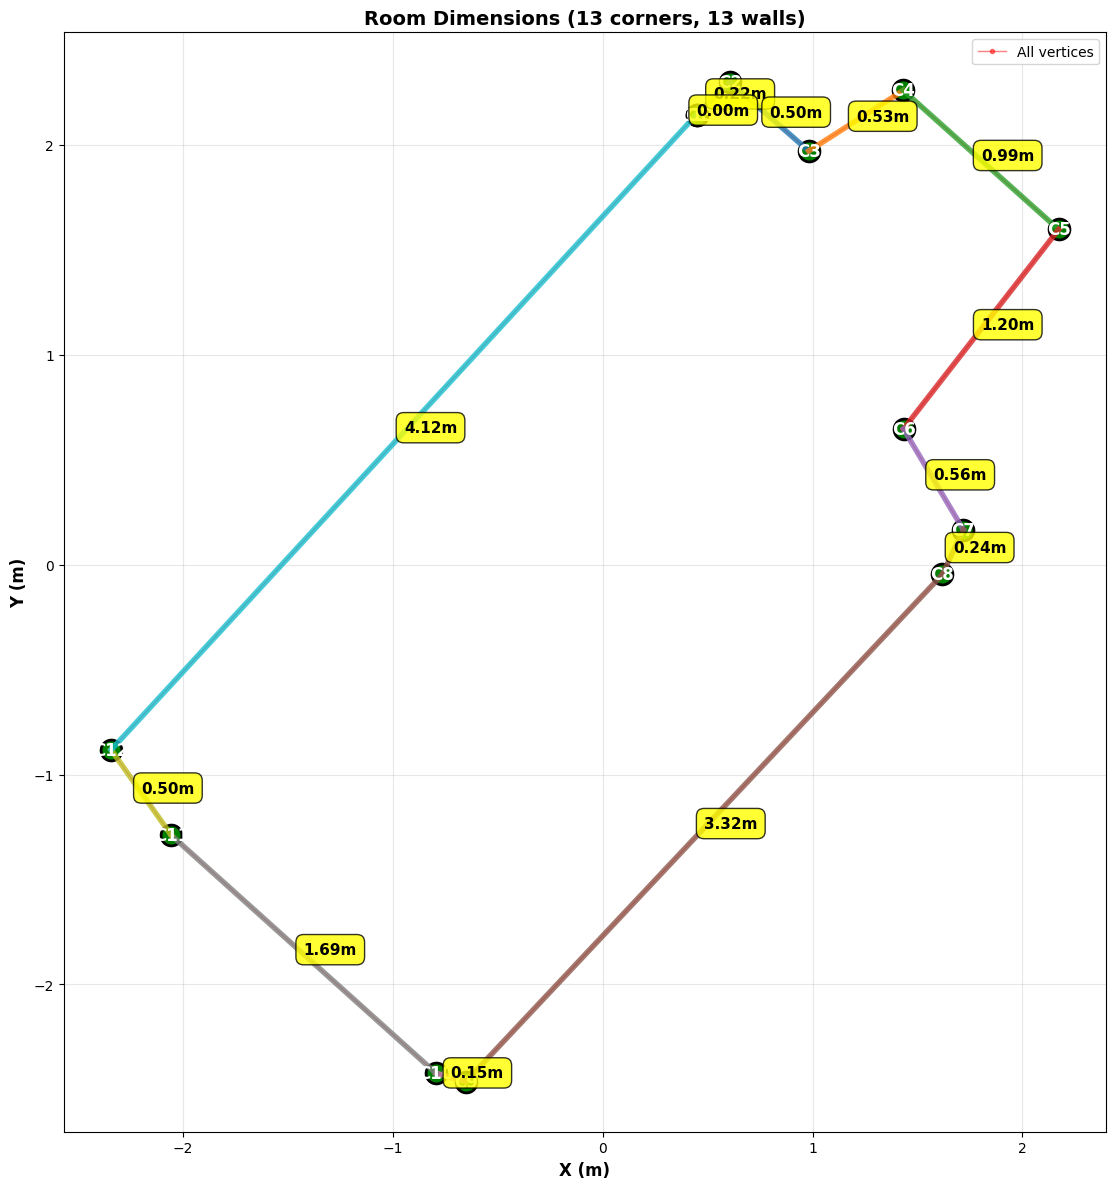

In [57]:
fig, ax = plt.subplots(figsize=(14, 12))

# Plot polygon
poly_closed = np.vstack([polygon_points, polygon_points[0]])
ax.plot(poly_closed[:, 0], poly_closed[:, 1], 'o-', 
        color='red', markersize=3, linewidth=1, alpha=0.5,
        label='All vertices')

# Mark corners with larger markers
for i, corner in enumerate(corners):
    pos = corner['position']
    ax.plot(pos[0], pos[1], 'go', markersize=15, 
            markeredgecolor='black', markeredgewidth=2)
    ax.text(pos[0], pos[1], f"C{i+1}", 
            fontsize=12, fontweight='bold', ha='center', va='center',
            color='white')

# Draw walls with dimensions
colors = plt.cm.tab10(np.linspace(0, 1, len(walls)))
for i, wall in enumerate(walls):
    # Draw wall
    ax.plot([wall['start_pos'][0], wall['end_pos'][0]],
            [wall['start_pos'][1], wall['end_pos'][1]],
            '-', color=colors[i], linewidth=4, alpha=0.8)
    
    # Label with dimension
    mid_x = (wall['start_pos'][0] + wall['end_pos'][0]) / 2
    mid_y = (wall['start_pos'][1] + wall['end_pos'][1]) / 2
    
    ax.text(mid_x, mid_y, f"{wall['length']:.2f}m",
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', 
                     facecolor='yellow', alpha=0.8, edgecolor='black'))

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax.set_title(f'Room Dimensions ({len(corners)} corners, {len(walls)} walls)', 
            fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

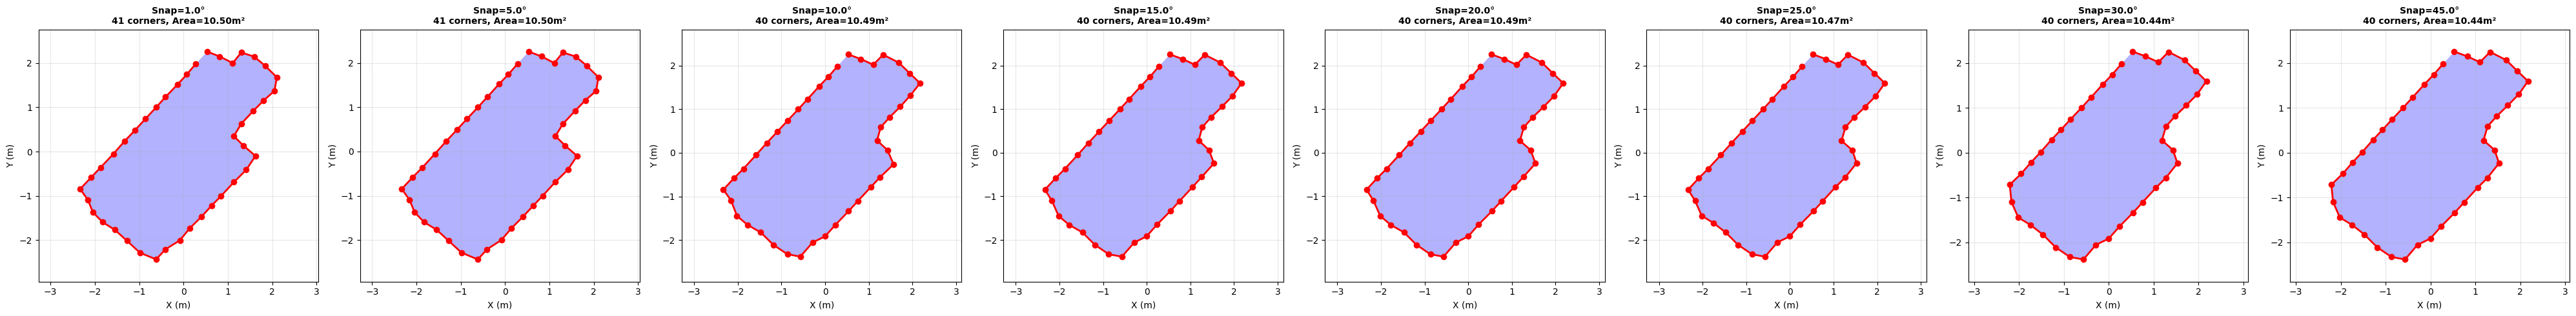


WANG-MÜLLER SIMPLIFICATION COMPARISON
Snap Threshold (°)   Vertices   Area (m²)    Perimeter (m)  
----------------------------------------------------------------------
1.0                  41         10.50        14.17          
5.0                  41         10.50        14.18          
10.0                 40         10.49        14.06          
15.0                 40         10.49        14.03          
20.0                 40         10.49        14.04          
25.0                 40         10.47        14.03          
30.0                 40         10.44        13.94          
45.0                 40         10.44        13.94          

RECOMMENDED: Snap threshold = 15-20° for best balance


In [392]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.signal import find_peaks


def detect_dominant_orientations(polygon_points, num_orientations=4, angular_bins=180):
    """Detect dominant wall orientations using histogram"""
    n = len(polygon_points)
    edge_angles = []
    edge_lengths = []
    
    for i in range(n):
        p1 = polygon_points[i]
        p2 = polygon_points[(i + 1) % n]
        vec = p2 - p1
        length = np.linalg.norm(vec)
        
        if length > 0.01:
            angle = np.arctan2(vec[1], vec[0])
            angle = angle % np.pi  # Normalize to [0, π)
            edge_angles.append(angle)
            edge_lengths.append(length)
    
    edge_angles = np.array(edge_angles)
    edge_lengths = np.array(edge_lengths)
    
    hist, bin_edges = np.histogram(edge_angles, bins=angular_bins, 
                                   range=(0, np.pi), weights=edge_lengths)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    peaks, _ = find_peaks(hist, prominence=np.max(hist) * 0.1)
    peak_prominences = hist[peaks]
    sorted_indices = np.argsort(peak_prominences)[::-1]
    dominant_peaks = peaks[sorted_indices[:num_orientations]]
    dominant_angles_rad = bin_centers[dominant_peaks]
    dominant_angles_deg = np.degrees(dominant_angles_rad)
    
    return dominant_angles_deg


def snap_edges_to_orientations(polygon_points, dominant_angles, snap_threshold=15.0):
    """Snap edges to nearest dominant orientation"""
    orientations = []
    for angle in dominant_angles:
        orientations.append(np.radians(angle))
        orientations.append(np.radians((angle + 90) % 180))
    orientations = np.array(orientations)
    directions = np.column_stack([np.cos(orientations), np.sin(orientations)])
    
    n = len(polygon_points)
    snapped_points = [polygon_points[0].copy()]
    
    for i in range(n):
        p1 = snapped_points[-1]
        p2_original = polygon_points[(i + 1) % n]
        edge_vec = p2_original - p1
        edge_length = np.linalg.norm(edge_vec)
        
        if edge_length < 0.01:
            continue
        
        edge_dir = edge_vec / edge_length
        edge_angle = np.arctan2(edge_dir[1], edge_dir[0]) % np.pi
        
        angle_diffs = np.abs(orientations - edge_angle)
        angle_diffs = np.minimum(angle_diffs, np.pi - angle_diffs)
        nearest_idx = np.argmin(angle_diffs)
        nearest_direction = directions[nearest_idx]
        
        if np.degrees(angle_diffs[nearest_idx]) <= snap_threshold:
            projected_length = np.dot(edge_vec, nearest_direction)
            p2_snapped = p1 + projected_length * nearest_direction
            snapped_points.append(p2_snapped)
        else:
            snapped_points.append(p2_original)
    
    return np.array(snapped_points[:-1])


def merge_nearby_vertices(polygon_points, distance_threshold=0.50):
    """Merge consecutive vertices that are too close"""
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    for i in range(1, len(polygon_points)):
        distance = np.linalg.norm(polygon_points[i] - merged[-1])
        if distance >= distance_threshold:
            merged.append(polygon_points[i])
    
    # Check wrap-around
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            merged = merged[:-1]
    
    return np.array(merged)


def wang_muller_simplification(polygon_points, num_orientations=4, 
                               snap_threshold=15.0, merge_distance=0.60):
    """Wang-Müller algorithm for building floorplans"""
    dominant_angles = detect_dominant_orientations(polygon_points, num_orientations)
    snapped = snap_edges_to_orientations(polygon_points, dominant_angles, snap_threshold)
    merged = merge_nearby_vertices(snapped, merge_distance)
    return merged


# ============================================================================
# COMPARISON VISUALIZATION
# ============================================================================

# Get your concave hull points
polygon_points = np.array(concave.exterior.coords)[:-1]

# Test different snap thresholds
snap_thresholds = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 45.0]

fig, axes = plt.subplots(1, len(snap_thresholds), figsize=(5*len(snap_thresholds), 5))

results = []

for idx, snap_threshold in enumerate(snap_thresholds):
    ax = axes[idx]
    
    # Apply Wang-Müller
    simplified_points = wang_muller_simplification(
        polygon_points.copy(),
        num_orientations=6,
        snap_threshold=snap_threshold,
        merge_distance=0.3
    )
    
    # Create polygon for area calculation
    simplified_poly = Polygon(simplified_points)
    
    # Plot
    x, y = simplified_points[:, 0], simplified_points[:, 1]
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified_points)
    area = simplified_poly.area
    
    ax.set_title(f'Snap={snap_threshold}°\n{corners} corners, Area={area:.2f}m²',
                fontsize=10, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    
    results.append({
        'threshold': snap_threshold,
        'vertices': corners,
        'area': area,
        'perimeter': simplified_poly.length
    })

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("WANG-MÜLLER SIMPLIFICATION COMPARISON")
print("="*70)
print(f"{'Snap Threshold (°)':<20} {'Vertices':<10} {'Area (m²)':<12} {'Perimeter (m)':<15}")
print("-"*70)

for r in results:
    print(f"{r['threshold']:<20.1f} {r['vertices']:<10} {r['area']:<12.2f} {r['perimeter']:<15.2f}")

print("\n" + "="*70)
print("RECOMMENDED: Snap threshold = 15-20° for best balance")
print("="*70)

### BY WALL

In [36]:
def segment_floor_ceiling_walls(points, 
                                ceiling_indices=None,
                                floor_method='histogram',
                                floor_ransac_threshold=0.02):
    """
    Complete segmentation: ceiling, floor, and walls
    
    Parameters:
    -----------
    points : np.ndarray (N, 3)
        Full point cloud
    ceiling_indices : np.ndarray, optional
        Indices of ceiling points (from previous detection)
        If None, will detect ceiling first
    floor_method : str
        'histogram' or 'ransac'
    floor_ransac_threshold : float
        RANSAC distance threshold for floor detection
    
    Returns:
    --------
    segmentation : dict
        {
            'ceiling_indices': np.ndarray,
            'floor_indices': np.ndarray,
            'wall_indices': np.ndarray,
            'ceiling_points': np.ndarray,
            'floor_points': np.ndarray,
            'wall_points': np.ndarray
        }
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE FLOOR/CEILING/WALL SEGMENTATION")
    print(f"{'='*70}")
    print(f"Total points: {len(points):,}")
    
    # Step 1: Get ceiling indices (if not provided)
    if ceiling_indices is None:
        print(f"\nStep 1: Detecting ceiling...")
        # Use your existing ceiling detection
        # from ceiling_detection import detect_and_refine_ceiling
        ceiling_indices = detect_and_refine_ceiling(points)
    else:
        print(f"\nStep 1: Using provided ceiling indices")
        print(f"  Ceiling points: {len(ceiling_indices):,}")
    
    # Step 2: Remove ceiling, detect floor
    print(f"\nStep 2: Detecting floor...")
    
    # Create mask for non-ceiling points
    non_ceiling_mask = np.ones(len(points), dtype=bool)
    non_ceiling_mask[ceiling_indices] = False
    non_ceiling_points = points[non_ceiling_mask]
    non_ceiling_indices = np.where(non_ceiling_mask)[0]
    
    print(f"  Remaining after ceiling removal: {len(non_ceiling_points):,}")
    
    # Detect floor
    if floor_method == 'histogram':
        floor_indices_local = detect_floor_histogram(non_ceiling_points)
    else:
        floor_indices_local = detect_floor_ransac(non_ceiling_points, 
                                                  floor_ransac_threshold)
    
    # Map back to original indices
    floor_indices = non_ceiling_indices[floor_indices_local]
    
    print(f"  Floor points detected: {len(floor_indices):,}")
    
    # Step 3: Remaining points = walls
    print(f"\nStep 3: Extracting walls...")
    
    all_structural = np.zeros(len(points), dtype=bool)
    all_structural[ceiling_indices] = True
    all_structural[floor_indices] = True
    
    wall_mask = ~all_structural
    wall_indices = np.where(wall_mask)[0]
    
    print(f"  Wall points: {len(wall_indices):,}")
    
    # Summary
    print(f"\n{'='*70}")
    print(f"SEGMENTATION SUMMARY")
    print(f"{'='*70}")
    print(f"Total points:   {len(points):,}")
    print(f"Ceiling:        {len(ceiling_indices):,} ({100*len(ceiling_indices)/len(points):.1f}%)")
    print(f"Floor:          {len(floor_indices):,} ({100*len(floor_indices)/len(points):.1f}%)")
    print(f"Walls:          {len(wall_indices):,} ({100*len(wall_indices)/len(points):.1f}%)")
    print(f"{'='*70}")
    
    return {
        'ceiling_indices': ceiling_indices,
        'floor_indices': floor_indices,
        'wall_indices': wall_indices,
        'ceiling_points': points[ceiling_indices],
        'floor_points': points[floor_indices],
        'wall_points': points[wall_indices]
    }


def detect_floor_histogram(points, bottom_slice_thickness=0.30, 
                           height_tolerance=0.05, min_points=1000):
    """
    Detect floor using histogram (similar to ceiling detection)
    
    Parameters:
    -----------
    points : np.ndarray (N, 3)
        Points (with ceiling already removed)
    bottom_slice_thickness : float
        Thickness of bottom slice to analyze (meters)
    height_tolerance : float
        Clustering tolerance for height grouping (meters)
    min_points : int
        Minimum points to consider valid floor
    
    Returns:
    --------
    floor_indices : np.ndarray
        Indices of floor points (in input array)
    """
    
    print(f"  Floor detection method: Histogram")
    
    z_coords = points[:, 2]
    min_z = z_coords.min()
    max_z_for_floor = min_z + bottom_slice_thickness
    
    print(f"    Min height: {min_z:.2f}m")
    print(f"    Floor slice: {min_z:.2f}m to {max_z_for_floor:.2f}m")
    
    # Extract bottom slice
    floor_mask = z_coords <= max_z_for_floor
    floor_slice = points[floor_mask]
    floor_slice_indices = np.where(floor_mask)[0]
    
    print(f"    Points in bottom slice: {len(floor_slice):,}")
    
    if len(floor_slice) < min_points:
        print(f"    ⚠️  Too few points in floor slice!")
        return np.array([], dtype=int)
    
    # Cluster by height using DBSCAN
    from sklearn.cluster import DBSCAN
    
    z_values = floor_slice[:, 2].reshape(-1, 1)
    clustering = DBSCAN(eps=height_tolerance, min_samples=50)
    labels = clustering.fit_predict(z_values)
    
    # Find largest cluster (main floor)
    unique_labels = set(labels)
    unique_labels.discard(-1)  # Remove noise
    
    if len(unique_labels) == 0:
        print(f"    ⚠️  No floor clusters found!")
        return np.array([], dtype=int)
    
    # Get largest cluster
    cluster_sizes = [(label, np.sum(labels == label)) for label in unique_labels]
    largest_cluster = max(cluster_sizes, key=lambda x: x[1])
    floor_cluster_label = largest_cluster[0]
    floor_cluster_size = largest_cluster[1]
    
    print(f"    Floor cluster: {floor_cluster_size:,} points")
    
    # Get indices of floor points
    floor_cluster_mask = (labels == floor_cluster_label)
    floor_indices = floor_slice_indices[floor_cluster_mask]
    
    return floor_indices


def detect_floor_ransac(points, distance_threshold=0.02, 
                       ransac_n=3, num_iterations=1000):
    """
    Detect floor using RANSAC plane fitting
    
    Parameters:
    -----------
    points : np.ndarray (N, 3)
        Points (with ceiling already removed)
    distance_threshold : float
        RANSAC inlier threshold (meters)
    
    Returns:
    --------
    floor_indices : np.ndarray
        Indices of floor points (in input array)
    """
    
    print(f"  Floor detection method: RANSAC")
    print(f"    Distance threshold: {distance_threshold}m")
    
    # Convert to Open3D
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # RANSAC plane fitting
    plane_model, inliers = pcd.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )
    
    [a, b, c, d] = plane_model
    
    print(f"    Floor plane: {a:.4f}x + {b:.4f}y + {c:.4f}z + {d:.4f} = 0")
    print(f"    Inliers: {len(inliers):,} / {len(points):,} ({100*len(inliers)/len(points):.1f}%)")
    
    # Check if plane is roughly horizontal (floor should be)
    normal_z = abs(c)
    if normal_z < 0.9:
        print(f"    ⚠️  WARNING: Plane not horizontal! Normal Z: {normal_z:.3f}")
    
    floor_indices = np.array(inliers)
    
    return floor_indices


def visualize_segmentation(points, segmentation, subsample=None):
    """
    Visualize ceiling/floor/wall segmentation
    
    Parameters:
    -----------
    points : np.ndarray (N, 3)
        Full point cloud
    segmentation : dict
        Output from segment_floor_ceiling_walls
    subsample : int, optional
        Subsample points for faster visualization
    """
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(18, 6))
    
    # Subsample if needed
    if subsample and len(points) > subsample:
        indices = np.random.choice(len(points), subsample, replace=False)
        points_vis = points[indices]
        
        # Create mapping
        ceiling_vis = np.isin(indices, segmentation['ceiling_indices'])
        floor_vis = np.isin(indices, segmentation['floor_indices'])
        wall_vis = np.isin(indices, segmentation['wall_indices'])
    else:
        points_vis = points
        ceiling_vis = np.isin(np.arange(len(points)), segmentation['ceiling_indices'])
        floor_vis = np.isin(np.arange(len(points)), segmentation['floor_indices'])
        wall_vis = np.isin(np.arange(len(points)), segmentation['wall_indices'])
    
    # Plot 1: All together
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points_vis[ceiling_vis, 0], points_vis[ceiling_vis, 1], points_vis[ceiling_vis, 2],
               c='red', s=1, alpha=0.5, label='Ceiling')
    ax1.scatter(points_vis[floor_vis, 0], points_vis[floor_vis, 1], points_vis[floor_vis, 2],
               c='green', s=1, alpha=0.5, label='Floor')
    ax1.scatter(points_vis[wall_vis, 0], points_vis[wall_vis, 1], points_vis[wall_vis, 2],
               c='blue', s=1, alpha=0.5, label='Walls')
    ax1.set_title('Complete Segmentation', fontweight='bold')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.legend()
    
    # Plot 2: Walls only (side view)
    ax2 = fig.add_subplot(132, projection='3d')
    wall_points = segmentation['wall_points']
    if subsample and len(wall_points) > subsample//2:
        wall_sample = wall_points[np.random.choice(len(wall_points), subsample//2, replace=False)]
    else:
        wall_sample = wall_points
    ax2.scatter(wall_sample[:, 0], wall_sample[:, 1], wall_sample[:, 2],
               c='blue', s=2, alpha=0.6)
    ax2.set_title(f'Walls Only ({len(wall_points):,} points)', fontweight='bold')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    
    # Plot 3: Top-down view (walls)
    ax3 = fig.add_subplot(133)
    ax3.scatter(wall_points[:, 0], wall_points[:, 1], c='blue', s=1, alpha=0.3)
    ax3.set_title('Walls (Top View)', fontweight='bold')
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [37]:
ceiling_indices = np.hstack([level["indices"] for level in refined_ceiling_levels])

In [38]:
segmentation = segment_floor_ceiling_walls(
    points,
    ceiling_indices=ceiling_indices,  # from ceiling detection
    floor_method='ransac',  # or 'histogram'
    floor_ransac_threshold=0.1
)


COMPLETE FLOOR/CEILING/WALL SEGMENTATION
Total points: 306,406

Step 1: Using provided ceiling indices
  Ceiling points: 69,528

Step 2: Detecting floor...
  Remaining after ceiling removal: 236,878
  Floor detection method: RANSAC
    Distance threshold: 0.1m
    Floor plane: 0.0068x + 0.0018y + 1.0000z + 1.2999 = 0
    Inliers: 56,977 / 236,878 (24.1%)
  Floor points detected: 56,977

Step 3: Extracting walls...
  Wall points: 179,901

SEGMENTATION SUMMARY
Total points:   306,406
Ceiling:        69,528 (22.7%)
Floor:          56,977 (18.6%)
Walls:          179,901 (58.7%)


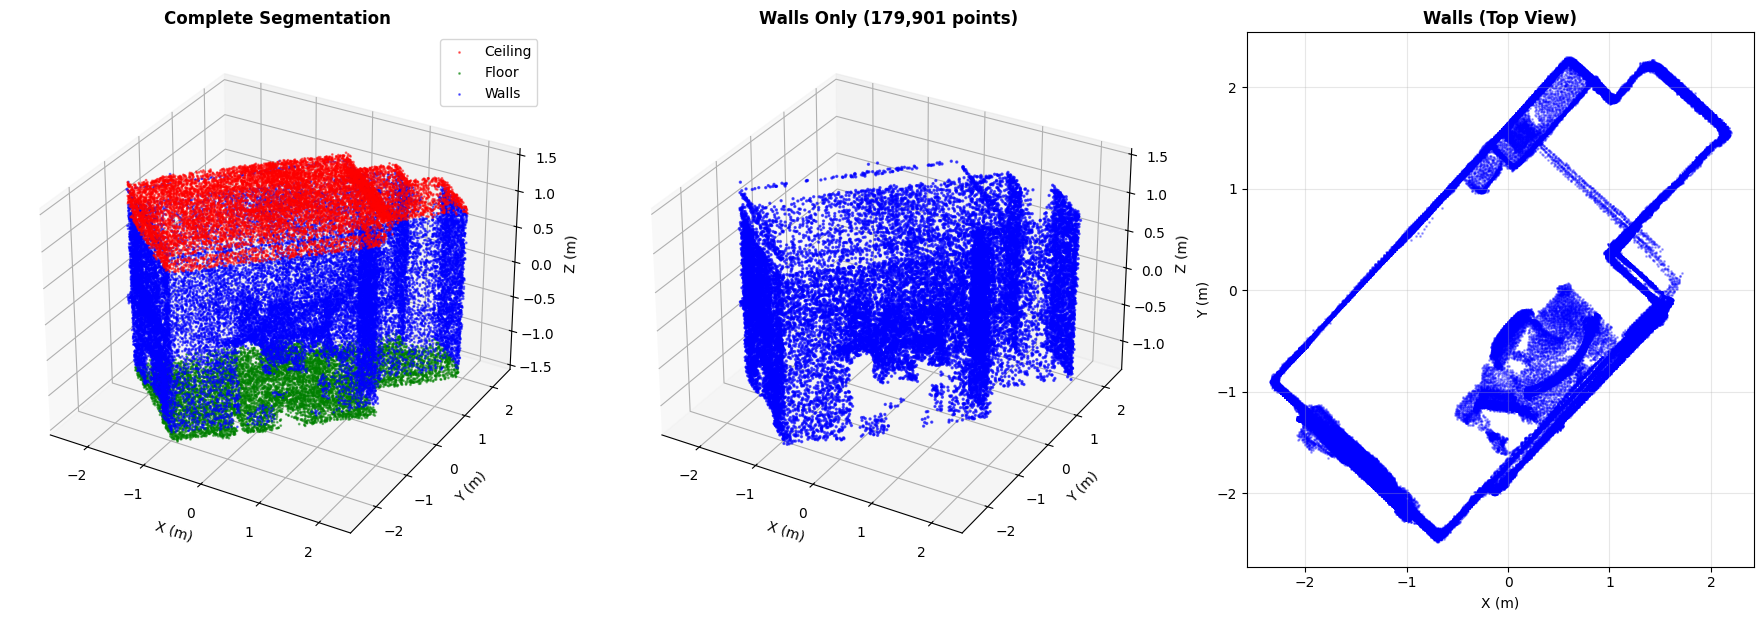

In [39]:
visualize_segmentation(points, segmentation, subsample=50000)

In [40]:
def extract_wall_points(points, floor_height, ceiling_height, 
                       floor_margin=0.1, ceiling_margin=0.1):
    """
    Keep only points between floor and ceiling (potential walls)
    
    Args:
        points: Nx3 array
        floor_height: float
        ceiling_height: float
        floor_margin: Distance above floor to include (m)
        ceiling_margin: Distance below ceiling to include (m)
    
    Returns:
        wall_points: Filtered points
        wall_mask: Boolean mask
    """
    z_values = points[:, 2]
    
    wall_mask = (z_values > floor_height + floor_margin) & \
                (z_values < ceiling_height - ceiling_margin)
    
    wall_points = points[wall_mask]
    
    print(f"Original points: {len(points)}")
    print(f"Wall points: {len(wall_points)} ({100*len(wall_points)/len(points):.1f}%)")
    
    return wall_points, wall_mask

In [41]:
def compute_normals(points, radius=0.1, max_nn=30):
    """
    Compute normal vectors for each point
    
    Args:
        points: Nx3 array
        radius: Search radius for normal estimation
        max_nn: Max number of neighbors
    
    Returns:
        normals: Nx3 array of normal vectors
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius, 
            max_nn=max_nn
        )
    )
    
    # Orient normals consistently (optional but helpful)
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    normals = np.asarray(pcd.normals)
    
    print(f"Computed normals for {len(normals)} points")
    
    return normals, pcd

In [42]:
def filter_vertical_points(points, normals, vertical_threshold=0.1):
    """
    Keep only points with vertical normals (walls)
    
    Args:
        points: Nx3 array
        normals: Nx3 array
        vertical_threshold: Max abs(normal_z) for vertical surfaces
    
    Returns:
        vertical_points: Filtered points
        vertical_normals: Corresponding normals
        vertical_mask: Boolean mask
    """
    # Vertical surfaces have normals with small Z component
    normal_z = np.abs(normals[:, 2])
    vertical_mask = normal_z < vertical_threshold
    
    vertical_points = points[vertical_mask]
    vertical_normals = normals[vertical_mask]
    
    print(f"Wall points: {len(points)}")
    print(f"Vertical wall points: {len(vertical_points)} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    
    return vertical_points, vertical_normals, vertical_mask

In [43]:
def visualize_wall_points(wall_points):
    """Visualize extracted wall points"""
    pcd_walls = o3d.geometry.PointCloud()
    pcd_walls.points = o3d.utility.Vector3dVector(wall_points)
    pcd_walls.paint_uniform_color([0, 1, 0])  # Green
    
    o3d.visualization.draw_geometries([pcd_walls], 
                                      window_name="Wall Points (Green)")

In [44]:
def extract_walls_complete_pipeline(points, floor_height, ceiling_height,
                                   floor_margin=0.10, ceiling_margin=0.10,
                                   normal_radius=0.10, max_nn=30,
                                   vertical_threshold=0.15):
    """
    Complete 3-step wall extraction pipeline
    
    Step 1: Height-based filtering (remove floor/ceiling + margins)
    Step 2: Normal computation
    Step 3: Vertical surface filtering
    
    Parameters:
    -----------
    points : np.ndarray (N, 3)
        Full point cloud
    floor_height : float
        Floor Z coordinate
    ceiling_height : float
        Ceiling Z coordinate
    floor_margin : float
        Distance above floor to exclude (m)
    ceiling_margin : float
        Distance below ceiling to exclude (m)
    normal_radius : float
        Radius for normal estimation (m)
    max_nn : int
        Max neighbors for normal estimation
    vertical_threshold : float
        Max |normal_z| for vertical surfaces
    
    Returns:
    --------
    result : dict
        {
            'wall_points': np.ndarray (M, 3) - final wall points,
            'wall_normals': np.ndarray (M, 3) - wall normals,
            'wall_indices': np.ndarray (M,) - original indices,
            'step1_points': np.ndarray - after height filtering,
            'step2_normals': np.ndarray - all computed normals,
            'pcd': o3d.PointCloud - with normals
        }
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE WALL EXTRACTION PIPELINE")
    print(f"{'='*70}")
    print(f"Input points: {len(points):,}")
    print(f"Floor height: {floor_height:.3f}m")
    print(f"Ceiling height: {ceiling_height:.3f}m")
    print(f"Safety margins: floor={floor_margin}m, ceiling={ceiling_margin}m")
    
    # STEP 1: Height-based filtering
    print(f"\n{'─'*70}")
    print(f"STEP 1: Height-based filtering")
    print(f"{'─'*70}")
    
    wall_points_step1, wall_mask_step1 = extract_wall_points(
        points,
        floor_height,
        ceiling_height,
        floor_margin=floor_margin,
        ceiling_margin=ceiling_margin
    )
    
    step1_indices = np.where(wall_mask_step1)[0]
    
    print(f"  Excluded: {len(points) - len(wall_points_step1):,} points "
          f"({100*(len(points) - len(wall_points_step1))/len(points):.1f}%)")
    
    # STEP 2: Normal computation
    print(f"\n{'─'*70}")
    print(f"STEP 2: Normal computation")
    print(f"{'─'*70}")
    print(f"  Normal radius: {normal_radius}m")
    print(f"  Max neighbors: {max_nn}")
    
    normals_step2, pcd = compute_normals(
        wall_points_step1,
        radius=normal_radius,
        max_nn=max_nn
    )
    
    # STEP 3: Vertical surface filtering
    print(f"\n{'─'*70}")
    print(f"STEP 3: Vertical surface filtering")
    print(f"{'─'*70}")
    print(f"  Vertical threshold: |normal_z| < {vertical_threshold}")
    
    vertical_points, vertical_normals, vertical_mask = filter_vertical_points(
        wall_points_step1,
        normals_step2,
        vertical_threshold=vertical_threshold
    )
    
    # Map back to original indices
    vertical_indices = step1_indices[vertical_mask]
    
    print(f"  Non-vertical removed: {len(wall_points_step1) - len(vertical_points):,} points "
          f"({100*(len(wall_points_step1) - len(vertical_points))/len(wall_points_step1):.1f}%)")
    
    # Summary
    print(f"\n{'='*70}")
    print(f"PIPELINE SUMMARY")
    print(f"{'='*70}")
    print(f"Input points:                 {len(points):,}")
    print(f"After Step 1 (height filter): {len(wall_points_step1):,} "
          f"({100*len(wall_points_step1)/len(points):.1f}%)")
    print(f"After Step 2 (normals):       {len(wall_points_step1):,} (same)")
    print(f"After Step 3 (vertical):      {len(vertical_points):,} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    print(f"\n✓ Final wall points: {len(vertical_points):,}")
    print(f"  Total reduction: {len(points) - len(vertical_points):,} "
          f"({100*(len(points) - len(vertical_points))/len(points):.1f}%)")
    print(f"{'='*70}")
    
    return {
        'wall_points': vertical_points,
        'wall_normals': vertical_normals,
        'wall_indices': vertical_indices,
        'step1_points': wall_points_step1,
        'step2_normals': normals_step2,
        'pcd': pcd
    }


def visualize_wall_pipeline(points, floor_height, ceiling_height, result):
    """
    Visualize the 3-step wall extraction process
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(20, 10))
    
    # Subsample for visualization
    subsample = 30000
    
    # Plot 1: Original point cloud
    ax1 = fig.add_subplot(231, projection='3d')
    if len(points) > subsample:
        idx = np.random.choice(len(points), subsample, replace=False)
        points_vis = points[idx]
    else:
        points_vis = points
    ax1.scatter(points_vis[:, 0], points_vis[:, 1], points_vis[:, 2],
               c=points_vis[:, 2], cmap='viridis', s=1, alpha=0.5)
    ax1.set_title(f'Step 0: Original\n{len(points):,} points', fontweight='bold')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Plot 2: After height filtering
    ax2 = fig.add_subplot(232, projection='3d')
    step1_pts = result['step1_points']
    if len(step1_pts) > subsample:
        idx = np.random.choice(len(step1_pts), subsample, replace=False)
        step1_vis = step1_pts[idx]
    else:
        step1_vis = step1_pts
    ax2.scatter(step1_vis[:, 0], step1_vis[:, 1], step1_vis[:, 2],
               c='orange', s=1, alpha=0.6)
    ax2.axhline(y=0, z=floor_height, color='green', linewidth=2, label='Floor')
    ax2.axhline(y=0, z=ceiling_height, color='red', linewidth=2, label='Ceiling')
    ax2.set_title(f'Step 1: Height Filter\n{len(step1_pts):,} points', fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Plot 3: After vertical filtering
    ax3 = fig.add_subplot(233, projection='3d')
    wall_pts = result['wall_points']
    if len(wall_pts) > subsample:
        idx = np.random.choice(len(wall_pts), subsample, replace=False)
        wall_vis = wall_pts[idx]
    else:
        wall_vis = wall_pts
    ax3.scatter(wall_vis[:, 0], wall_vis[:, 1], wall_vis[:, 2],
               c='blue', s=1, alpha=0.6)
    ax3.set_title(f'Step 3: Vertical Only\n{len(wall_pts):,} points', fontweight='bold')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    
    # Plot 4: Top view - Step 1
    ax4 = fig.add_subplot(234)
    ax4.scatter(step1_pts[:, 0], step1_pts[:, 1], c='orange', s=0.5, alpha=0.3)
    ax4.set_title('Step 1: Top View', fontweight='bold')
    ax4.set_xlabel('X (m)')
    ax4.set_ylabel('Y (m)')
    ax4.set_aspect('equal')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Top view - Step 3 (walls)
    ax5 = fig.add_subplot(235)
    ax5.scatter(wall_pts[:, 0], wall_pts[:, 1], c='blue', s=0.5, alpha=0.5)
    ax5.set_title('Step 3: Walls Top View', fontweight='bold')
    ax5.set_xlabel('X (m)')
    ax5.set_ylabel('Y (m)')
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Normal distribution
    ax6 = fig.add_subplot(236)
    normal_z = result['step2_normals'][:, 2]
    ax6.hist(np.abs(normal_z), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax6.axvline(0.15, color='red', linestyle='--', linewidth=2, label='Vertical threshold')
    ax6.set_xlabel('|Normal Z|', fontweight='bold')
    ax6.set_ylabel('Count', fontweight='bold')
    ax6.set_title('Normal Z Distribution', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [45]:
floor_height, ceiling_height = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [46]:
floor_height, ceiling_height

(np.float64(-1.3150331875), np.float64(1.34621995))

In [47]:
wall_result = extract_walls_complete_pipeline(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    floor_margin=0.10,        # 10cm margin
    ceiling_margin=0.25,      # 10cm margin
    normal_radius=0.10,       # 10cm for normal estimation
    max_nn=30,
    vertical_threshold=0.15   # |normal_z| < 0.15 = vertical
)


COMPLETE WALL EXTRACTION PIPELINE
Input points: 306,406
Floor height: -1.315m
Ceiling height: 1.346m
Safety margins: floor=0.1m, ceiling=0.25m

──────────────────────────────────────────────────────────────────────
STEP 1: Height-based filtering
──────────────────────────────────────────────────────────────────────
Original points: 306406
Wall points: 185216 (60.4%)
  Excluded: 121,190 points (39.6%)

──────────────────────────────────────────────────────────────────────
STEP 2: Normal computation
──────────────────────────────────────────────────────────────────────
  Normal radius: 0.1m
  Max neighbors: 30
Computed normals for 185216 points

──────────────────────────────────────────────────────────────────────
STEP 3: Vertical surface filtering
──────────────────────────────────────────────────────────────────────
  Vertical threshold: |normal_z| < 0.15
Wall points: 185216
Vertical wall points: 129561 (70.0%)
  Non-vertical removed: 55,655 points (30.0%)

PIPELINE SUMMARY
Input poi

In [48]:
vertical_points = wall_result["wall_points"]
vertical_normals = wall_result["wall_normals"]

In [49]:
pcd_vert = o3d.geometry.PointCloud()
pcd_vert.points = o3d.utility.Vector3dVector(vertical_points)
pcd_vert.normals = o3d.utility.Vector3dVector(vertical_normals)
pcd_vert.paint_uniform_color([1, 0, 1])  # magenta
o3d.visualization.draw_geometries([pcd_vert], window_name="Vertical Wall Points")

In [136]:
vertical_points

array([[ 1.26945  ,  0.677628 ,  0.271659 ],
       [-2.296216 , -0.973427 , -0.608072 ],
       [ 1.564725 , -0.184736 ,  0.027237 ],
       ...,
       [ 0.497898 , -1.327315 ,  0.014815 ],
       [-1.638524 , -1.457743 , -1.02008  ],
       [-0.2581475, -1.9942415,  0.3199655]], shape=(129561, 3))

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_85521/901727530.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


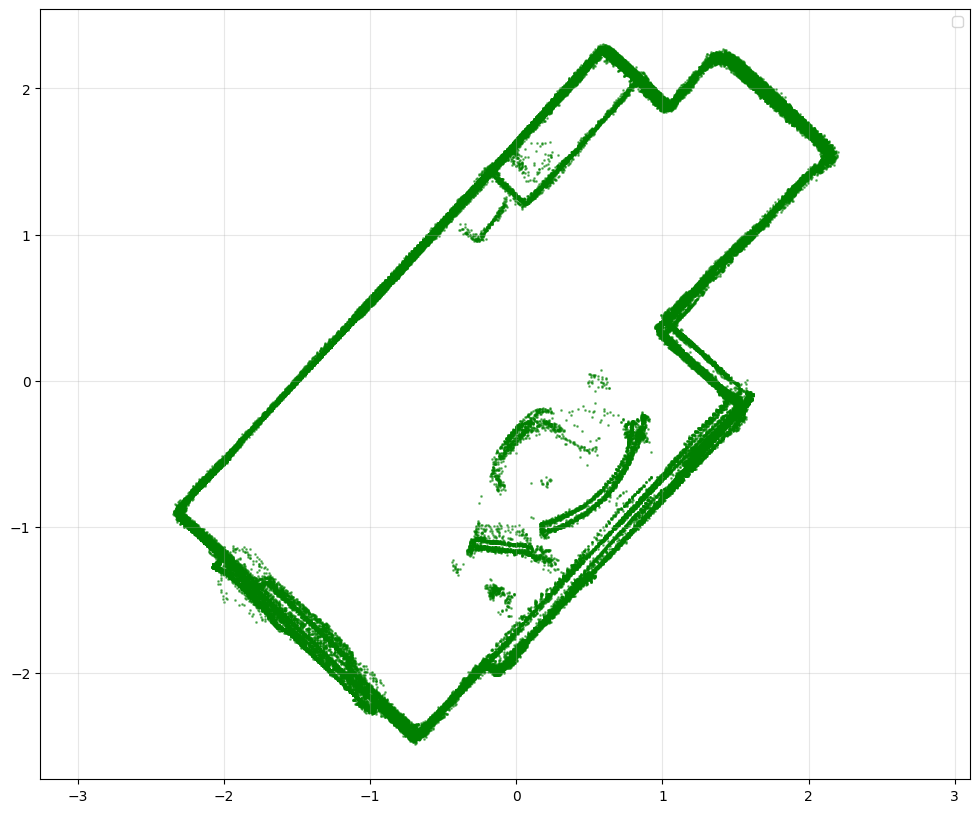

In [50]:
wall_points_2d = vertical_points[: , :2]

plt.figure(figsize=(12, 10))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='green', s=1,  alpha=0.5)
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

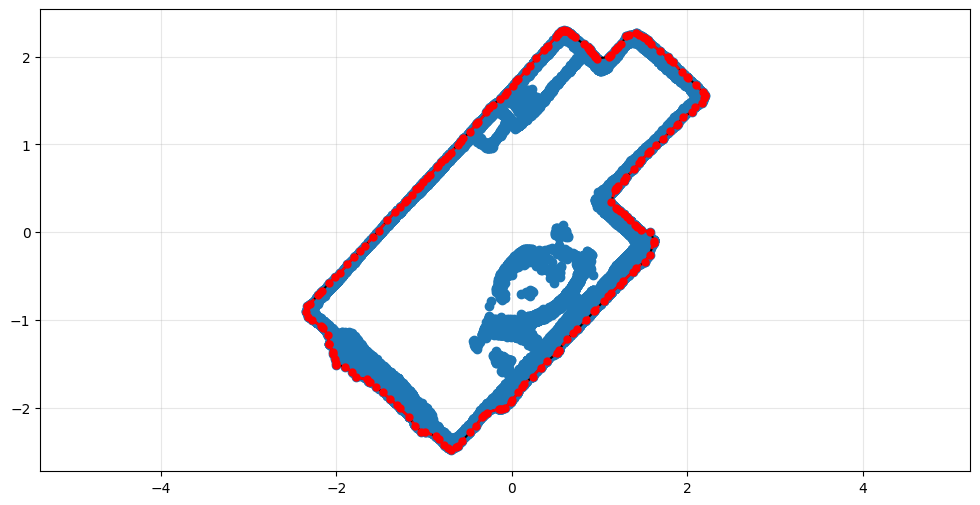

In [51]:
multi_point = MultiPoint(wall_points_2d)
concave = shapely.concave_hull(multi_point, ratio=0.05)

plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if concave.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = concave.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
concave.area

10.549938974922448

In [53]:
def compute_wall_geometry_robust(wall_points, room_height):
    """
    Robust wall geometry computation with fallback methods
    
    Returns:
        dict with length, height, thickness, area
    """
    
    # Height is always reliable
    z_values = wall_points[:, 2]
    wall_height = z_values.max() - z_values.min()
    
    # 2D points
    points_2d = wall_points[:, :2]
    
    if len(points_2d) < 3:
        return None
    
    # Method 1: Try PCA (best when it works)
    try:
        from sklearn.decomposition import PCA
        
        # Check if points are not all identical
        if np.std(points_2d) < 1e-6:
            raise ValueError("Points are identical")
        
        pca = PCA(n_components=2)
        pca.fit(points_2d)
        
        # Check if PCA is valid
        if np.any(np.isnan(pca.components_)) or np.any(np.isinf(pca.components_)):
            raise ValueError("PCA produced invalid results")
        
        transformed = pca.transform(points_2d)
        
        # Check transformed values
        if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)):
            raise ValueError("Transform produced invalid results")
        
        length = transformed[:, 0].max() - transformed[:, 0].min()
        thickness = transformed[:, 1].max() - transformed[:, 1].min()
        
        wall_length = max(length, thickness)
        wall_thickness = min(length, thickness)
        
        # Sanity check
        if wall_length < 0.01 or wall_thickness < 0:
            raise ValueError("Invalid dimensions from PCA")
        
    except Exception as e:
        # Method 2: Fallback - use bounding box
        print(f"    PCA failed ({str(e)[:50]}), using bounding box")
        
        min_x, min_y = points_2d.min(axis=0)
        max_x, max_y = points_2d.max(axis=0)
        
        length_x = max_x - min_x
        length_y = max_y - min_y
        
        wall_length = max(length_x, length_y)
        wall_thickness = min(length_x, length_y)
    
    wall_area = wall_length * wall_height
    height_ratio = wall_height / room_height
    
    return {
        'length': wall_length,
        'height': wall_height,
        'thickness': wall_thickness,
        'area': wall_area,
        'height_ratio': height_ratio
    }


def detect_walls_ransac_clustering(vertical_points,
                                   floor_height, ceiling_height,
                                   distance_threshold=0.03,
                                   cluster_eps=0.10,
                                   min_cluster_points=100,
                                   min_wall_height=1.5,
                                   min_wall_length=0.80,  # Increased from 0.1!
                                   max_wall_thickness=0.25,
                                   min_height_ratio=0.50,  # NEW: wall must span 50% of room height
                                   max_iterations=30):
    """
    Detect walls using RANSAC + DBSCAN clustering (ROBUST VERSION)
    """
    
    print(f"\n{'='*70}")
    print(f"WALL DETECTION: RANSAC + DBSCAN (ROBUST)")
    print(f"{'='*70}")
    print(f"Total vertical points: {len(vertical_points):,}")
    
    room_height = ceiling_height - floor_height
    print(f"Room height: {room_height:.2f}m")
    print(f"Min wall length: {min_wall_length}m")
    print(f"Min height ratio: {min_height_ratio*100:.0f}%")
    
    walls = []
    remaining_points = vertical_points.copy()
    
    for iteration in range(max_iterations):
        if len(remaining_points) < min_cluster_points:
            print(f"\n✓ Stopping: Only {len(remaining_points)} points remaining")
            break
        
        print(f"\n{'-'*70}")
        print(f"Iteration {iteration + 1}/{max_iterations}")
        print(f"Remaining: {len(remaining_points):,} points")
        
        # STEP 1: RANSAC
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(remaining_points)
        
        plane_model, inliers_idx = pcd.segment_plane(
            distance_threshold=distance_threshold,
            ransac_n=3,
            num_iterations=1000
        )
        
        if len(inliers_idx) < min_cluster_points:
            print(f"  ⚠️  Plane too small: {len(inliers_idx)} points")
            break
        
        [a, b, c, d] = plane_model
        print(f"  Plane: {len(inliers_idx)} inliers, n=[{a:.3f}, {b:.3f}, {c:.3f}]")
        
        # Check verticality
        if abs(c) > 0.3:
            print(f"  ⚠️  Not vertical (|nz|={abs(c):.2f})")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        inlier_points = remaining_points[inliers_idx]
        
        # STEP 2: DBSCAN
        pcd_inliers = o3d.geometry.PointCloud()
        pcd_inliers.points = o3d.utility.Vector3dVector(inlier_points)
        
        labels = np.array(pcd_inliers.cluster_dbscan(
            eps=cluster_eps,
            min_points=min_cluster_points
        ))
        
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[unique_labels >= 0]
        
        if len(unique_labels) == 0:
            print(f"  ⚠️  No valid clusters")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        # Find largest cluster
        cluster_sizes = [np.sum(labels == label) for label in unique_labels]
        largest_idx = unique_labels[np.argmax(cluster_sizes)]
        largest_size = max(cluster_sizes)
        
        print(f"  Clusters: {len(unique_labels)}, largest: {largest_size:,} pts")
        
        # Extract largest cluster
        wall_mask = (labels == largest_idx)
        wall_points = inlier_points[wall_mask]
        
        # STEP 3: Compute geometry (ROBUST)
        geometry = compute_wall_geometry_robust(wall_points, room_height)
        
        if geometry is None:
            print(f"  ⚠️  Geometry computation failed")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        wall_length = geometry['length']
        wall_height = geometry['height']
        wall_thickness = geometry['thickness']
        wall_area = geometry['area']
        height_ratio = geometry['height_ratio']
        
        # STEP 4: Validate
        is_valid = (
            wall_height >= min_wall_height and
            wall_length >= min_wall_length and
            wall_thickness <= max_wall_thickness and
            height_ratio >= min_height_ratio and  # NEW!
            largest_size >= min_cluster_points
        )
        
        print(f"  Geo: L={wall_length:.2f}m, H={wall_height:.2f}m ({height_ratio*100:.0f}%), "
              f"T={wall_thickness:.2f}m")
        
        if not is_valid:
            print(f"  ❌ Rejected")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        # STEP 5: Store
        center = wall_points.mean(axis=0)
        normal = np.array([a, b, c])
        
        wall_info = {
            'wall_id': len(walls) + 1,
            'plane_model': plane_model,
            'normal': normal,
            'center': center,
            'points': wall_points,
            'num_points': largest_size,
            'length': wall_length,
            'height': wall_height,
            'thickness': wall_thickness,
            'area': wall_area,
            'height_ratio': height_ratio
        }
        
        walls.append(wall_info)
        
        print(f"  ✅ Wall {len(walls)}: {largest_size:,} pts, "
              f"{wall_length:.2f}m × {wall_height:.2f}m")
        
        remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
    
    print(f"\n{'='*70}")
    print(f"COMPLETE: {len(walls)} walls detected")
    print(f"{'='*70}")
    
    return walls

In [132]:
walls = detect_walls_ransac_clustering(
    vertical_points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.02,      # 3cm RANSAC
    cluster_eps=0.12,             # 12cm clustering
    min_cluster_points=50,       # At least 100 points
    min_wall_height=1.8,          # ← Increased! At least 1.8m tall
    min_wall_length=0.10,         # ← Increased! At least 80cm long
    max_wall_thickness=0.25,      # Max 25cm thick
    min_height_ratio=0.60,        # ← NEW! Must span 60% of room height
    max_iterations=30
)


WALL DETECTION: RANSAC + DBSCAN (ROBUST)
Total vertical points: 129,561
Room height: 2.66m
Min wall length: 0.1m
Min height ratio: 60%

----------------------------------------------------------------------
Iteration 1/30
Remaining: 129,561 points
  Plane: 29780 inliers, n=[0.736, -0.677, 0.001]
  Clusters: 1, largest: 29,759 pts
  Geo: L=4.37m, H=2.31m (87%), T=0.06m
  ✅ Wall 1: 29,759 pts, 4.37m × 2.31m

----------------------------------------------------------------------
Iteration 2/30
Remaining: 99,781 points
  Plane: 11825 inliers, n=[0.711, -0.703, -0.003]
  Clusters: 2, largest: 11,387 pts
  Geo: L=1.75m, H=2.27m (85%), T=0.04m
  ✅ Wall 2: 11,387 pts, 1.75m × 2.27m

----------------------------------------------------------------------
Iteration 3/30
Remaining: 87,956 points
  Plane: 10180 inliers, n=[0.688, 0.725, 0.006]
  Clusters: 1, largest: 9,668 pts
  Geo: L=2.26m, H=2.31m (87%), T=0.04m
  ✅ Wall 3: 9,668 pts, 2.26m × 2.31m

---------------------------------------------

/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

  Clusters: 2, largest: 7,603 pts
  Geo: L=3.23m, H=2.31m (87%), T=0.07m
  ✅ Wall 4: 7,603 pts, 3.23m × 2.31m

----------------------------------------------------------------------
Iteration 5/30
Remaining: 67,410 points
  Plane: 6169 inliers, n=[0.659, 0.752, 0.005]
  Clusters: 1, largest: 6,163 pts
  Geo: L=1.11m, H=2.28m (86%), T=0.06m
  ✅ Wall 5: 6,163 pts, 1.11m × 2.28m

----------------------------------------------------------------------
Iteration 6/30
Remaining: 61,241 points
  Plane: 6645 inliers, n=[0.689, 0.725, -0.004]
  Clusters: 2, largest: 6,135 pts
  Geo: L=0.88m, H=2.26m (85%), T=0.05m
  ✅ Wall 6: 6,135 pts, 0.88m × 2.26m

----------------------------------------------------------------------
Iteration 7/30
Remaining: 54,596 points
  Plane: 6995 inliers, n=[0.735, -0.678, -0.014]
  Clusters: 2, largest: 6,585 pts
  Geo: L=2.61m, H=1.96m (74%), T=0.07m
  ✅ Wall 7: 6,585 pts, 2.61m × 1.96m

----------------------------------------------------------------------
Iteratio

/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

In [133]:
def get_room_wall_points(walls):
    """
    Extract all wall points for a specific room
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
               Format: {room_id: [wall1, wall2, ...]}
               Each wall has: {'inliers': Nx3 array, 'plane_model': [a,b,c,d], ...}
        room_id: Room ID (integer)
    
    Returns:
        points_3d: Nx3 numpy array of all wall points in this room
                   Returns empty array if room not found or has no walls
    """
    
    
    room_walls = walls.copy()
    
    
    # Collect all point clouds from all wall segments
    all_points = []
    
    for i, wall in enumerate(room_walls):
        wall_points = wall['points']  # Nx3 array
        all_points.append(wall_points)
    
    # Stack all points into single array
    combined_points = np.vstack(all_points)
    
    
    return combined_points

In [134]:
wall_points = get_room_wall_points(walls)

In [135]:
def project_points_to_2d(points_3d):
    """
    Project 3D wall points to 2D (X-Y plane)
    
    Args:
        points_3d: Nx3 numpy array (X, Y, Z coordinates)
    
    Returns:
        points_2d: Nx2 numpy array (X, Y coordinates)
    """
    if len(points_3d) == 0:
        return np.array([])
    
    # Simply take X and Y columns (ignore Z)
    points_2d = points_3d[:, :2]
    
    print(f"Projected {len(points_3d)} points to 2D")
    print(f"2D bounds:")
    print(f"  X: [{points_2d[:, 0].min():.3f}, {points_2d[:, 0].max():.3f}] "
          f"(range: {points_2d[:, 0].max() - points_2d[:, 0].min():.3f}m)")
    print(f"  Y: [{points_2d[:, 1].min():.3f}, {points_2d[:, 1].max():.3f}] "
          f"(range: {points_2d[:, 1].max() - points_2d[:, 1].min():.3f}m)")
    
    return points_2d

In [136]:
wall_points_2d = project_points_to_2d(wall_points)

Projected 82494 points to 2D
2D bounds:
  X: [-2.350, 2.191] (range: 4.541m)
  Y: [-2.487, 2.302] (range: 4.789m)


In [137]:
def visualize_2d_points(points_2d, title="2D Wall Points", downsample=1):
    """
    Visualize 2D points with matplotlib
    
    Args:
        points_2d: Nx2 numpy array
        title: Plot title
        downsample: Plot every Nth point (for speed with large datasets)
    """
    if len(points_2d) == 0:
        print("No points to visualize")
        return
    
    # Downsample for visualization
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
        print(f"Plotting {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    else:
        points_to_plot = points_2d
    
    plt.figure(figsize=(10, 6))
    plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                s=1, c='blue', alpha=0.5)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

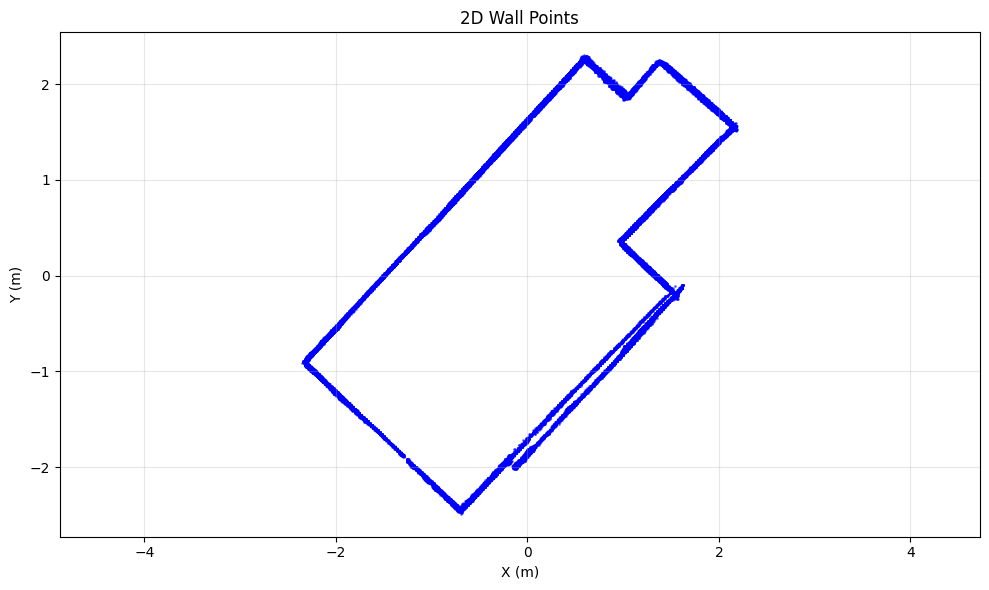

In [138]:
visualize_2d_points(wall_points_2d)

In [139]:
def extract_room_boundary_from_walls(wall_points_2d, 
                                     method='concave_hull',
                                     concave_ratio=0.05,
                                     alpha=1.0):
    """
    Extract room boundary polygon from all wall points
    
    Methods:
    - 'concave_hull': Shapely concave hull (best for your case)
    - 'alpha_shape': Alpha shapes
    
    Parameters:
    -----------
    wall_points_2d : np.ndarray (N, 2)
        All wall points (X, Y only)
    method : str
        Boundary extraction method
    concave_ratio : float
        For concave_hull method (0-1, lower = tighter fit)
    alpha : float
        For alpha_shape method
    
    Returns:
    --------
    boundary_polygon : shapely.Polygon
        Room boundary
    """
    
    import shapely
    from shapely.geometry import MultiPoint, Polygon
    
    print(f"\n{'='*70}")
    print(f"BOUNDARY EXTRACTION FROM WALL POINTS")
    print(f"{'='*70}")
    print(f"Wall points: {len(wall_points_2d):,}")
    print(f"Method: {method}")
    
    # Create multipoint
    multi_point = MultiPoint(wall_points_2d)
    
    if method == 'concave_hull':
        # Use shapely's concave hull (perfect for this!)
        boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
        
        print(f"Concave hull ratio: {concave_ratio}")
        
    elif method == 'alpha_shape':
        # Alpha shapes (alternative)
        from shapely.ops import unary_union
        from scipy.spatial import Delaunay
        
        # Compute Delaunay triangulation
        tri = Delaunay(wall_points_2d)
        
        # Filter triangles by edge length (alpha parameter)
        edges = set()
        for simplex in tri.simplices:
            for i in range(3):
                p1 = wall_points_2d[simplex[i]]
                p2 = wall_points_2d[simplex[(i+1)%3]]
                edge_length = np.linalg.norm(p2 - p1)
                
                if edge_length < alpha:
                    edge = tuple(sorted([simplex[i], simplex[(i+1)%3]]))
                    edges.add(edge)
        
        # Build polygon from edges (simplified)
        # This is complex, using concave_hull is easier
        boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Validate
    if not isinstance(boundary, Polygon):
        print(f"⚠️  Result is not a polygon, converting...")
        boundary = boundary.convex_hull
    
    # Get stats
    area = boundary.area
    perimeter = boundary.length
    num_vertices = len(boundary.exterior.coords) - 1
    
    print(f"\n✓ Boundary extracted:")
    print(f"  Vertices: {num_vertices}")
    print(f"  Perimeter: {perimeter:.2f}m")
    print(f"  Area: {area:.2f}m²")
    
    return boundary

In [140]:
all_wall_points = []
for wall in walls:
    all_wall_points.append(wall['points'])

In [141]:
all_wall_points = np.vstack(all_wall_points)
print(f"\nTotal wall points from all walls: {len(all_wall_points):,}")


Total wall points from all walls: 82,494


In [142]:
wall_points_2d = all_wall_points[:, :2]

In [145]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=0.03  # Try 0.03, 0.05, 0.10
)


BOUNDARY EXTRACTION FROM WALL POINTS
Wall points: 82,494
Method: concave_hull
Concave hull ratio: 0.03

✓ Boundary extracted:
  Vertices: 277
  Perimeter: 14.66m
  Area: 10.14m²


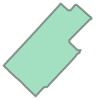

In [146]:
boundary_polygon

In [147]:
polygon_points = np.array(boundary_polygon.exterior.coords)[:-1]

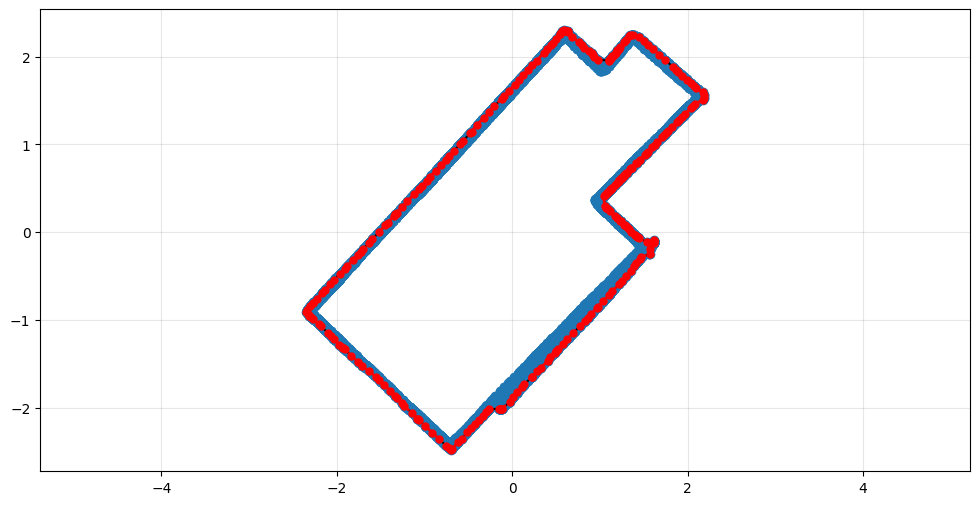

In [148]:
multi_point = MultiPoint(wall_points_2d)
# concave = shapely.concave_hull(multi_point, ratio=0.05)

plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if boundary_polygon.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = boundary_polygon.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

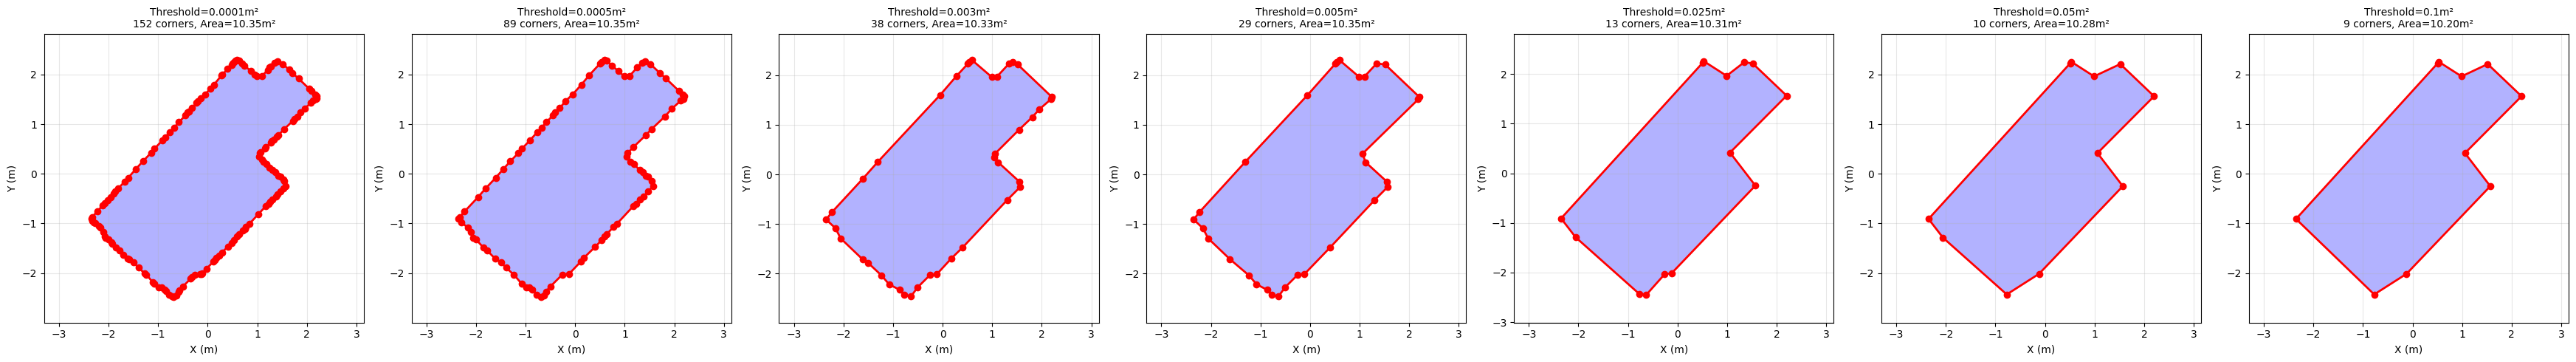


VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON
Threshold (m²)  Vertices   Area (m²) 
----------------------------------------------------------------------
0.0001          152        10.35     
0.0005          89         10.35     
0.0030          38         10.33     
0.0050          29         10.35     
0.0250          13         10.31     
0.0500          10         10.28     
0.1000          9          10.20     


In [ ]:
from simplification.cutil import simplify_coords_vw


# Get your concave hull points
# polygon_points = np.array(concave.exterior.coords)

# V-W uses "effective area" threshold (m²), not distance
# Smaller threshold = more detail, larger threshold = more simplified
thresholds = [0.0001, 0.0005, 0.003, 0.005, 0.025, 0.05, 0.1]

fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):
    ax = axes[idx]
    
    # Apply Visvalingam-Whyatt simplification
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    
    # Create polygon for area calculation
    simplified_poly = Polygon(simplified_points)
    
    # Plot
    x, y = simplified_points[:, 0], simplified_points[:, 1]
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified_points) - 1
    area = simplified_poly.area
    
    # # Test 10-point deviation if enough points
    # if len(simplified_points) >= 10:
    #     # from wall_segment_detection import fit_line_to_points
    #     _, _, err = fit_line_to_points(simplified_points[0:10])
    #     error_text = f'\n10-pt err: {err*100:.1f}cm'
    # else:
    #     error_text = ''
    
    ax.set_title(f'Threshold={threshold}m²\n{corners} corners, Area={area:.2f}m²',
                fontsize=10)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

# Also print summary
print("\n" + "="*70)
print("VISVALINGAM-WHYATT SIMPLIFICATION COMPARISON")
print("="*70)
print(f"{'Threshold (m²)':<15} {'Vertices':<10} {'Area (m²)':<10}")
print("-"*70)

for threshold in thresholds:
    simplified_points = simplify_coords_vw(polygon_points, epsilon=threshold)
    poly = Polygon(simplified_points)
    
    
    print(f"{threshold:<15.4f} {len(simplified_points)-1:<10} {poly.area:<10.2f}")

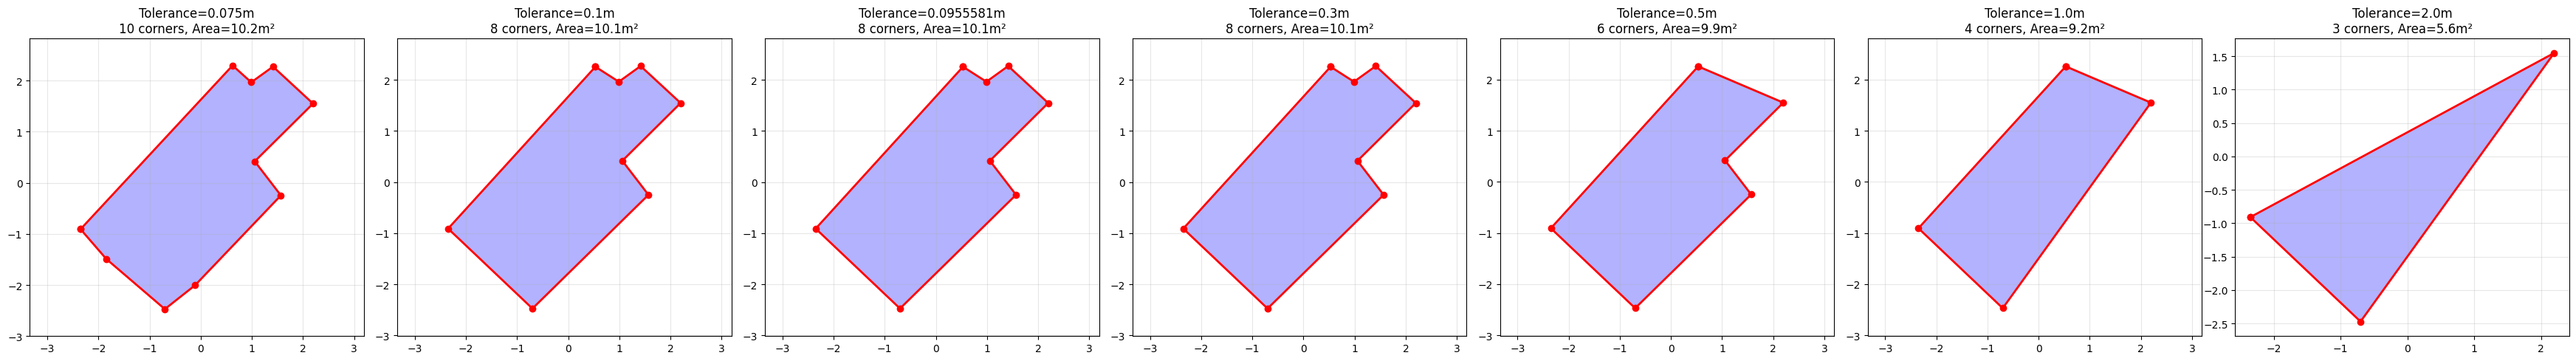

In [113]:
room_size = max(wall_points_2d[:, 0].max() - wall_points_2d[:, 0].min(),
                wall_points_2d[:, 1].max() - wall_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size
tolerances = [0.075, 0.1, recommended_tolerance, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(tolerances), figsize=(5*len(tolerances), 5))

for idx, tolerance in enumerate(tolerances):
    ax = axes[idx]
    
    # mimplify
    simplified = boundary_polygon.simplify(tolerance, preserve_topology=True)
    
    x, y = simplified.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified.exterior.coords) - 1
    area = simplified.area
    
    ax.set_title(f'Tolerance={tolerance}m\n{corners} corners, Area={area:.1f}m²')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [114]:
def compute_polygon_dimensions(polygon_points):
    """
    Compute wall dimensions from polygon vertices
    
    Each vertex = corner
    Each edge = wall
    Distance between consecutive vertices = wall length
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Simplified polygon vertices (ordered)
    
    Returns:
    --------
    dimensions : list of dict
        Each wall dimension
    """
    
    print(f"\n{'='*70}")
    print(f"POLYGON DIMENSIONS")
    print(f"{'='*70}")
    print(f"Number of corners: {len(polygon_points)}")
    
    n = len(polygon_points)
    dimensions = []
    
    for i in range(n):
        # Corner i to corner i+1
        p1 = polygon_points[i]
        p2 = polygon_points[(i + 1) % n]  # Wrap around
        
        # Wall vector
        vec = p2 - p1
        length = np.linalg.norm(vec)
        
        # Wall angle (from +X axis)
        angle_rad = np.arctan2(vec[1], vec[0])
        angle_deg = np.degrees(angle_rad) % 360
        
        dimensions.append({
            'wall_id': i + 1,
            'corner_start': i + 1,
            'corner_end': (i + 1) % n + 1,
            'start_point': p1,
            'end_point': p2,
            'length': length,
            'angle': angle_deg
        })
        
        print(f"Wall {i+1:2d}: Corner {i+1} → Corner {(i+1)%n + 1}, "
              f"Length: {length:6.3f}m, Angle: {angle_deg:6.1f}°")
    
    # Total perimeter
    total_perimeter = sum(d['length'] for d in dimensions)
    
    # Area (using shoelace formula)
    from shapely.geometry import Polygon
    area = Polygon(polygon_points).area
    
    print(f"\n{'─'*70}")
    print(f"Total perimeter: {total_perimeter:.3f}m")
    print(f"Total area:      {area:.3f}m²")
    print(f"{'='*70}")
    
    return dimensions


def visualize_polygon_dimensions(polygon_points, dimensions):
    """
    Visualize polygon with labeled dimensions
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Close polygon for plotting
    poly_closed = np.vstack([polygon_points, polygon_points[0]])
    
    # Plot polygon edges
    ax.plot(poly_closed[:, 0], poly_closed[:, 1], 
            'b-', linewidth=2, alpha=0.6)
    
    # Plot corners
    ax.plot(polygon_points[:, 0], polygon_points[:, 1],
            'ro', markersize=12, markeredgecolor='black', 
            markeredgewidth=2, label='Corners')
    
    # Label corners
    for i, point in enumerate(polygon_points):
        ax.text(point[0], point[1], f"C{i+1}",
                fontsize=11, fontweight='bold',
                ha='center', va='center',
                color='white')
    
    # Label wall dimensions
    for dim in dimensions:
        # Midpoint
        mid_x = (dim['start_point'][0] + dim['end_point'][0]) / 2
        mid_y = (dim['start_point'][1] + dim['end_point'][1]) / 2
        
        # Offset label perpendicular to wall
        vec = dim['end_point'] - dim['start_point']
        length = np.linalg.norm(vec)
        if length > 0:
            vec_norm = vec / length
            # Perpendicular vector (rotate 90°)
            perp = np.array([-vec_norm[1], vec_norm[0]])
            offset = 0.15  # 15cm offset
            label_x = mid_x + perp[0] * offset
            label_y = mid_y + perp[1] * offset
        else:
            label_x, label_y = mid_x, mid_y
        
        # Label
        ax.text(label_x, label_y, 
                f"W{dim['wall_id']}\n{dim['length']:.2f}m",
                fontsize=10, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='yellow', alpha=0.8,
                         edgecolor='black', linewidth=1.5))
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
    
    # Title with summary
    total_perim = sum(d['length'] for d in dimensions)
    area = Polygon(polygon_points).area
    ax.set_title(f'Room Dimensions\n'
                f'{len(polygon_points)} corners, '
                f'Perimeter: {total_perim:.2f}m, '
                f'Area: {area:.2f}m²',
                fontsize=14, fontweight='bold')
    
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [268]:
dp_poly = boundary_polygon.simplify(0.08, preserve_topology=True)

In [269]:
dp_poly = np.array(dp_poly.exterior.coords)[:-1]

In [270]:
dimensions = compute_polygon_dimensions(dp_poly)


POLYGON DIMENSIONS
Number of corners: 9
Wall  1: Corner 1 → Corner 2, Length:  0.621m, Angle:  328.0°
Wall  2: Corner 2 → Corner 3, Length:  0.495m, Angle:   43.8°
Wall  3: Corner 3 → Corner 4, Length:  1.065m, Angle:  317.3°
Wall  4: Corner 4 → Corner 5, Length:  1.614m, Angle:  224.7°
Wall  5: Corner 5 → Corner 6, Length:  0.840m, Angle:  308.1°
Wall  6: Corner 6 → Corner 7, Length:  2.431m, Angle:  226.3°
Wall  7: Corner 7 → Corner 8, Length:  0.752m, Angle:  218.3°
Wall  8: Corner 8 → Corner 9, Length:  2.272m, Angle:  136.5°
Wall  9: Corner 9 → Corner 1, Length:  4.281m, Angle:   47.7°

──────────────────────────────────────────────────────────────────────
Total perimeter: 14.371m
Total area:      10.208m²


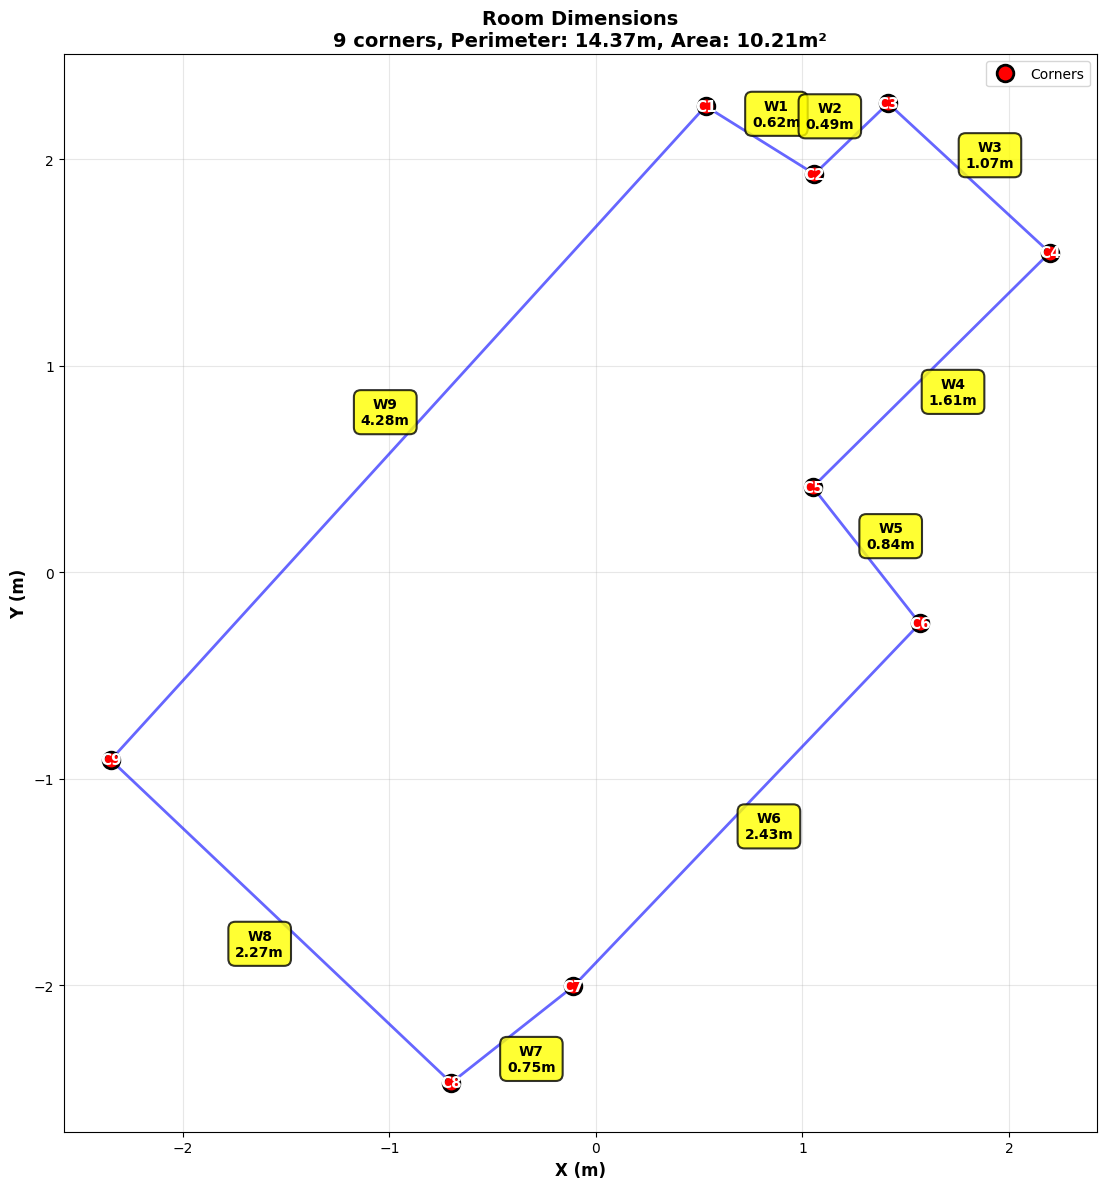

In [271]:
visualize_polygon_dimensions(dp_poly, dimensions)

In [157]:
simplified_points = simplify_coords_vw(polygon_points, epsilon=0.04)

In [152]:
dimensions = compute_polygon_dimensions(simplified_points)


POLYGON DIMENSIONS
Number of corners: 11
Wall  1: Corner 1 → Corner 2, Length:  0.543m, Angle:  327.4°
Wall  2: Corner 2 → Corner 3, Length:  0.583m, Angle:   25.2°
Wall  3: Corner 3 → Corner 4, Length:  0.942m, Angle:  316.5°
Wall  4: Corner 4 → Corner 5, Length:  1.618m, Angle:  225.1°
Wall  5: Corner 5 → Corner 6, Length:  0.840m, Angle:  307.5°
Wall  6: Corner 6 → Corner 7, Length:  2.444m, Angle:  226.3°
Wall  7: Corner 7 → Corner 8, Length:  0.774m, Angle:  212.5°
Wall  8: Corner 8 → Corner 9, Length:  1.718m, Angle:  138.4°
Wall  9: Corner 9 → Corner 10, Length:  0.479m, Angle:  127.7°
Wall 10: Corner 10 → Corner 11, Length:  4.242m, Angle:   47.7°
Wall 11: Corner 11 → Corner 1, Length:  0.038m, Angle:   50.2°

──────────────────────────────────────────────────────────────────────
Total perimeter: 14.221m
Total area:      10.276m²


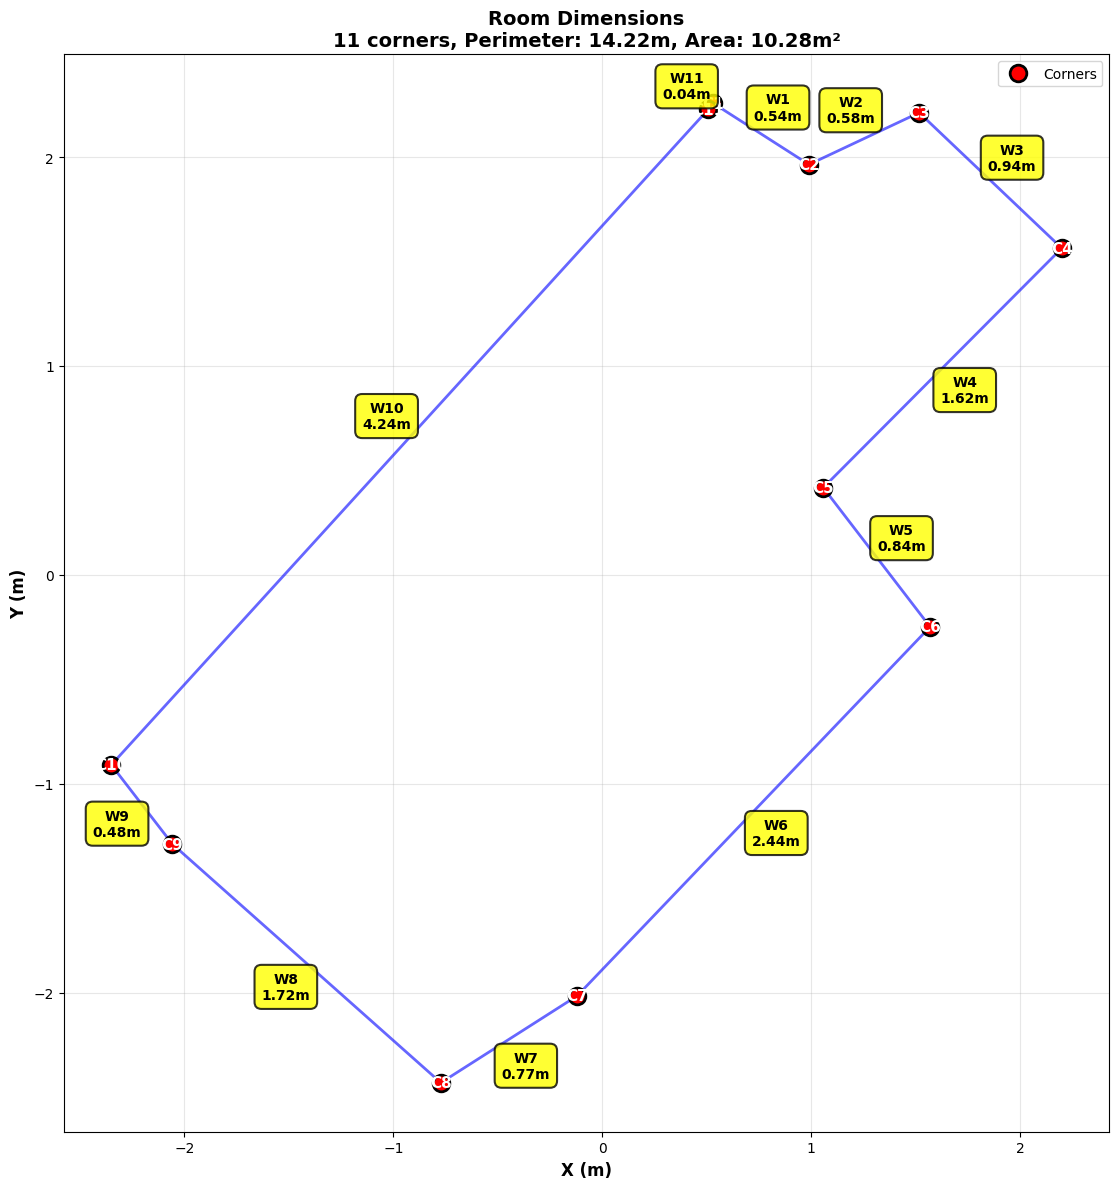

In [153]:
visualize_polygon_dimensions(simplified_points, dimensions)

In [154]:
def compute_median_wall_thickness(walls):
    """
    Compute median wall thickness from detected walls
    
    Parameters:
    -----------
    walls : list of dict
        Detected walls from RANSAC (with 'thickness' field)
    
    Returns:
    --------
    median_thickness : float
        Median wall thickness (meters)
    """
    
    thicknesses = [w['thickness'] for w in walls if w['thickness'] < 0.5]
    
    if len(thicknesses) == 0:
        print("⚠️  No valid wall thickness measurements!")
        return 0.15  # Default: 15cm
    
    median = np.median(thicknesses)
    mean = np.mean(thicknesses)
    
    print(f"\n{'='*70}")
    print(f"WALL THICKNESS ANALYSIS")
    print(f"{'='*70}")
    print(f"Walls analyzed: {len(thicknesses)}")
    print(f"Median thickness: {median:.3f}m ({median*100:.1f}cm)")
    print(f"Mean thickness: {mean:.3f}m ({mean*100:.1f}cm)")
    print(f"Range: {min(thicknesses):.3f}m - {max(thicknesses):.3f}m")
    
    return median

In [150]:
wall_points_2d

array([[ 0.30812 ,  1.978954],
       [-0.634541,  0.944066],
       [-0.048465,  1.573528],
       ...,
       [ 1.082534,  1.884825],
       [ 1.040882,  1.88177 ],
       [ 1.13783 ,  1.996977]], shape=(82494, 2))

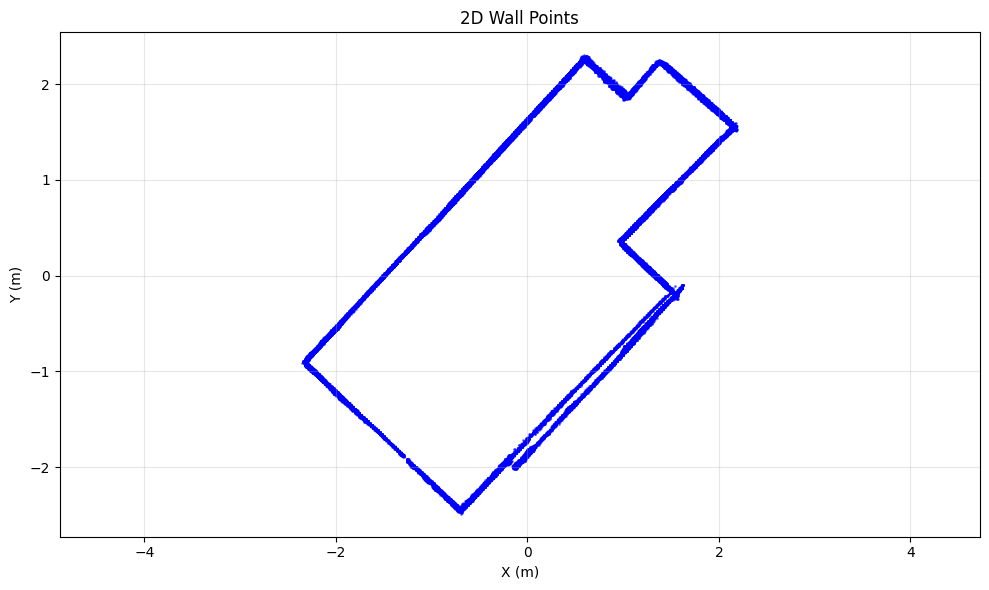

In [159]:
visualize_2d_points(wall_points_2d)

In [157]:
np.mean(wall_points_2d, axis=1)

array([1.143537 , 0.1547625, 0.7625315, ..., 1.4836795, 1.461326 ,
       1.5674035], shape=(82494,))

In [155]:
def offset_boundary_inward(boundary_polygon, offset_distance):
    """
    Shrink boundary polygon inward by offset distance
    
    This converts EXPLICIT boundary (scan surface) 
    to IMPLICIT boundary (wall centerline or inner edge)
    
    Parameters:
    -----------
    boundary_polygon : shapely.Polygon
        Original boundary (from concave hull)
    offset_distance : float
        Distance to offset inward (meters)
        - Use wall_thickness/2 for centerline
        - Use wall_thickness for inner edge
    
    Returns:
    --------
    offset_polygon : shapely.Polygon
        Offset boundary
    """
    
    print(f"\n{'='*70}")
    print(f"BOUNDARY OFFSET (EXPLICIT → IMPLICIT)")
    print(f"{'='*70}")
    print(f"Offset distance: {offset_distance:.3f}m ({offset_distance*100:.1f}cm)")
    
    # Negative buffer = shrink inward
    offset_polygon = boundary_polygon.buffer(-offset_distance)
    
    # Check result
    if offset_polygon.is_empty:
        print("⚠️  Offset too large! Polygon collapsed.")
        print("   Using half offset...")
        offset_polygon = boundary_polygon.buffer(-offset_distance/2)
    
    original_area = boundary_polygon.area
    offset_area = offset_polygon.area
    area_reduction = original_area - offset_area
    
    print(f"\nOriginal area: {original_area:.2f}m²")
    print(f"Offset area:   {offset_area:.2f}m²")
    print(f"Reduction:     {area_reduction:.2f}m² ({area_reduction/original_area*100:.1f}%)")
    
    return offset_polygon

In [156]:
median_thickness = compute_median_wall_thickness(walls)


WALL THICKNESS ANALYSIS
Walls analyzed: 10
Median thickness: 0.087m (8.7cm)
Mean thickness: 0.095m (9.5cm)
Range: 0.067m - 0.156m


In [160]:
poly = Polygon(simplified_points)

In [163]:
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=median_thickness / 2  # Half thickness = centerline
)


BOUNDARY OFFSET (EXPLICIT → IMPLICIT)
Offset distance: 0.044m (4.4cm)

Original area: 10.35m²
Offset area:   9.72m²
Reduction:     0.63m² (6.1%)


In [164]:
polygon_implicit = np.array(offset_implicit.exterior.coords)[:-1]

In [179]:
simplified_points = simplify_coords_vw(polygon_implicit, epsilon=0.001)

In [180]:
dimensions = compute_polygon_dimensions(simplified_points)


POLYGON DIMENSIONS
Number of corners: 62
Wall  1: Corner 1 → Corner 2, Length:  0.097m, Angle:  108.0°
Wall  2: Corner 2 → Corner 3, Length:  0.105m, Angle:  125.4°
Wall  3: Corner 3 → Corner 4, Length:  0.231m, Angle:  138.7°
Wall  4: Corner 4 → Corner 5, Length:  0.156m, Angle:   49.8°
Wall  5: Corner 5 → Corner 6, Length:  0.398m, Angle:   46.7°
Wall  6: Corner 6 → Corner 7, Length:  0.240m, Angle:   48.9°
Wall  7: Corner 7 → Corner 8, Length:  0.286m, Angle:   46.5°
Wall  8: Corner 8 → Corner 9, Length:  0.447m, Angle:   48.4°
Wall  9: Corner 9 → Corner 10, Length:  0.346m, Angle:   47.4°
Wall 10: Corner 10 → Corner 11, Length:  0.582m, Angle:   46.7°
Wall 11: Corner 11 → Corner 12, Length:  0.146m, Angle:   50.3°
Wall 12: Corner 12 → Corner 13, Length:  0.384m, Angle:   46.0°
Wall 13: Corner 13 → Corner 14, Length:  0.182m, Angle:   51.2°
Wall 14: Corner 14 → Corner 15, Length:  0.202m, Angle:   42.9°
Wall 15: Corner 15 → Corner 16, Length:  0.260m, Angle:   48.0°
Wall 16: Corner

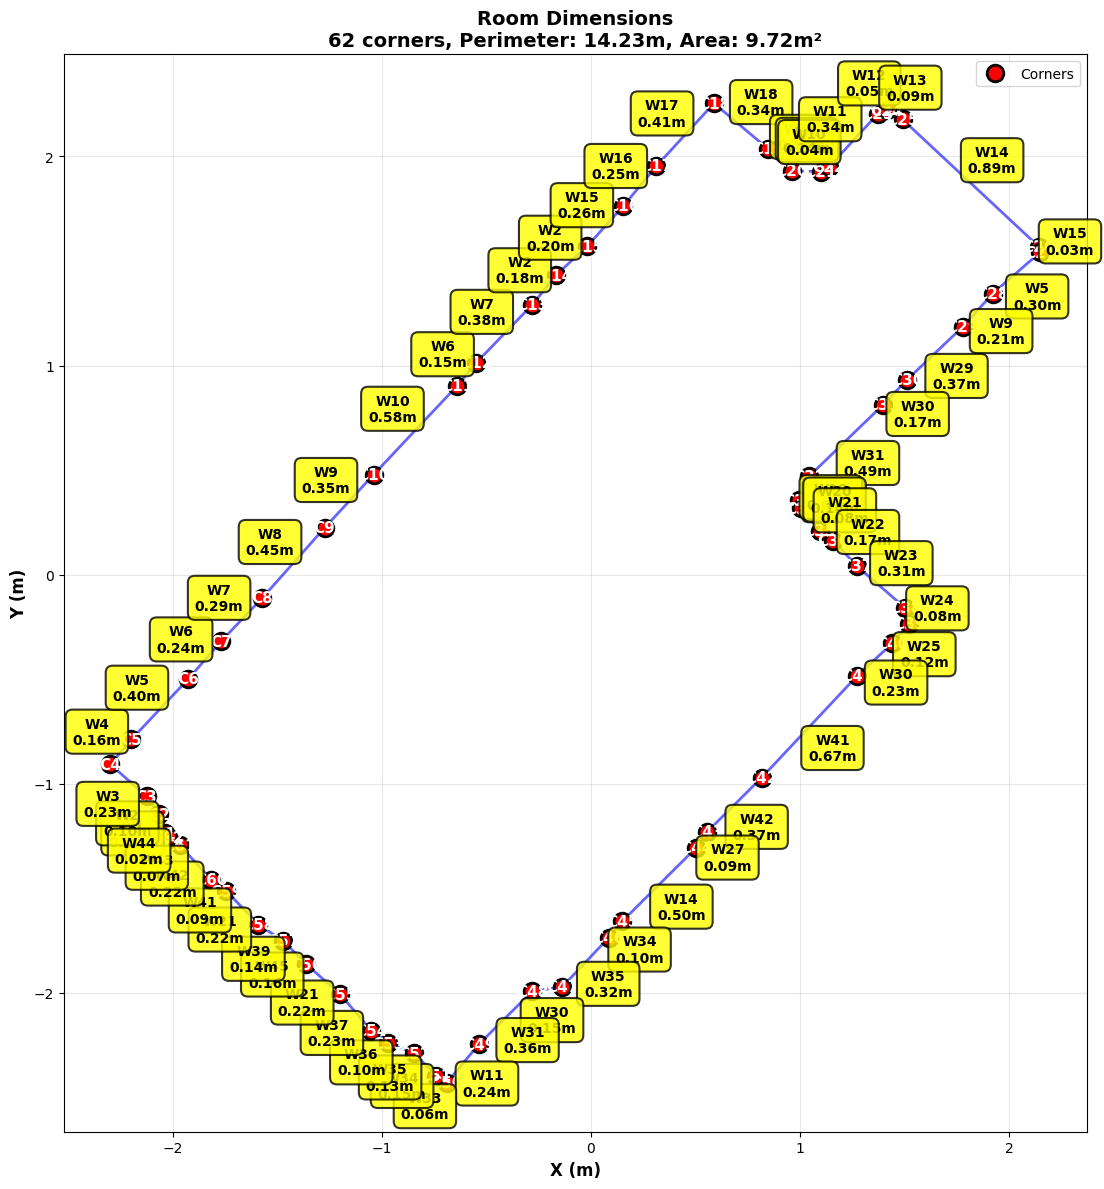

In [233]:
visualize_polygon_dimensions(simplified_points, dimensions)

In [234]:
def merge_nearby_vertices_simple(polygon_points, distance_threshold=0.10):
    """
    Merge consecutive vertices that are very close together
    
    This preserves perimeter accuracy while reducing vertex count!
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Polygon vertices in order
    distance_threshold : float
        Merge vertices closer than this (meters)
    
    Returns:
    --------
    merged_points : np.ndarray (M, 2)
        Simplified polygon (M ≤ N)
    """
    
    print(f"\n{'='*70}")
    print(f"SIMPLE VERTEX MERGING")
    print(f"{'='*70}")
    print(f"Input vertices: {len(polygon_points)}")
    print(f"Distance threshold: {distance_threshold}m")
    
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    
    for i in range(1, len(polygon_points)):
        current = polygon_points[i]
        previous = merged[-1]
        
        distance = np.linalg.norm(current - previous)
        
        if distance >= distance_threshold:
            # Far enough, keep this vertex
            merged.append(current)
        else:
            # Too close, skip (merge with previous)
            print(f"  Merging vertex {i} with previous (distance: {distance:.3f}m)")
    
    # Check wrap-around (last to first)
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            print(f"  Merging last vertex with first (distance: {distance_to_start:.3f}m)")
            merged = merged[:-1]
    
    merged_points = np.array(merged)
    
    print(f"\n✓ Result: {len(polygon_points)} → {len(merged_points)} vertices")
    
    # Check perimeter preservation
    from shapely.geometry import Polygon
    original_perim = Polygon(polygon_points).length
    merged_perim = Polygon(merged_points).length
    
    print(f"\nPerimeter check:")
    print(f"  Original: {original_perim:.3f}m")
    print(f"  Merged:   {merged_perim:.3f}m")
    print(f"  Diff:     {abs(original_perim - merged_perim):.3f}m "
          f"({100*abs(original_perim - merged_perim)/original_perim:.2f}%)")
    
    return merged_points

In [236]:
merged_points = merge_nearby_vertices_simple(simplified_points)


SIMPLE VERTEX MERGING
Input vertices: 62
Distance threshold: 0.1m
  Merging vertex 1 with previous (distance: 0.097m)
  Merging vertex 21 with previous (distance: 0.044m)
  Merging vertex 23 with previous (distance: 0.046m)
  Merging vertex 26 with previous (distance: 0.026m)
  Merging vertex 33 with previous (distance: 0.041m)
  Merging vertex 35 with previous (distance: 0.081m)
  Merging vertex 38 with previous (distance: 0.080m)
  Merging vertex 43 with previous (distance: 0.093m)
  Merging vertex 50 with previous (distance: 0.062m)
  Merging vertex 53 with previous (distance: 0.099m)
  Merging vertex 59 with previous (distance: 0.092m)
  Merging vertex 61 with previous (distance: 0.068m)
  Merging last vertex with first (distance: 0.088m)

✓ Result: 62 → 49 vertices

Perimeter check:
  Original: 14.229m
  Merged:   14.163m
  Diff:     0.065m (0.46%)


In [182]:
def merge_collinear_walls(dimensions, 
                         angle_tolerance=5.0,
                         max_gap=0.10):
    """
    Merge walls that are collinear (on same line)
    
    Strategy:
    1. Find pairs of consecutive walls with similar angles
    2. Check if they're collinear (approximately on same line)
    3. Merge them into single wall
    4. Repeat until no more merges possible
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions from compute_polygon_dimensions()
    angle_tolerance : float
        Max angle difference to consider collinear (degrees)
    max_gap : float
        Maximum gap between walls to merge (meters)
    
    Returns:
    --------
    merged_dimensions : list of dict
        Merged wall dimensions
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Max gap: {max_gap}m")
    
    merged = []
    skip_indices = set()
    
    i = 0
    while i < len(dimensions):
        if i in skip_indices:
            i += 1
            continue
        
        # Start new merged segment
        current = dimensions[i]
        merge_chain = [i]
        
        # Try to extend forward
        j = i + 1
        while j < len(dimensions):
            if j in skip_indices:
                j += 1
                continue
            
            next_wall = dimensions[j]
            
            # Check angle similarity
            angle_diff = abs(current['angle'] - next_wall['angle'])
            # Handle wrap-around (e.g., 359° and 1°)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            if angle_diff <= angle_tolerance:
                # Check gap
                gap = np.linalg.norm(current['end_point'] - next_wall['start_point'])
                
                if gap <= max_gap:
                    # Merge!
                    merge_chain.append(j)
                    current = next_wall  # Continue from this wall
                    j += 1
                else:
                    # Gap too large
                    break
            else:
                # Angle too different
                break
        
        # Create merged wall from chain
        if len(merge_chain) == 1:
            # No merge, keep original
            merged.append(dimensions[i])
        else:
            # Merge multiple walls
            first_wall = dimensions[merge_chain[0]]
            last_wall = dimensions[merge_chain[-1]]
            
            # New wall from first start to last end
            merged_start = first_wall['start_point']
            merged_end = last_wall['end_point']
            merged_vec = merged_end - merged_start
            merged_length = np.linalg.norm(merged_vec)
            merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
            
            # Sum of individual lengths (for comparison)
            total_length = sum(dimensions[idx]['length'] for idx in merge_chain)
            
            merged_wall = {
                'wall_id': len(merged) + 1,
                'start_point': merged_start,
                'end_point': merged_end,
                'length': merged_length,
                'angle': merged_angle,
                'merged_from': merge_chain,
                'num_segments': len(merge_chain)
            }
            
            merged.append(merged_wall)
            
            print(f"  Merged {len(merge_chain)} walls (indices {merge_chain[0]}-{merge_chain[-1]}): "
                  f"{total_length:.2f}m → {merged_length:.2f}m")
            
            # Mark as processed
            skip_indices.update(merge_chain)
        
        i += 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(merged)} walls")
    
    # Renumber
    for idx, wall in enumerate(merged, 1):
        wall['wall_id'] = idx
    
    return merged


def merge_short_walls(dimensions, min_wall_length=0.30):
    """
    Merge very short walls with their neighbors
    
    Strategy:
    - Find walls shorter than threshold
    - Merge with neighbor (prefer same angle)
    - Repeat
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Walls shorter than this get merged (meters)
    
    Returns:
    --------
    merged : list of dict
        Dimensions with short walls merged
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING SHORT WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Convert to list for easier manipulation
    walls = list(dimensions)
    
    iterations = 0
    max_iterations = 50
    
    while iterations < max_iterations:
        iterations += 1
        
        # Find shortest wall
        shortest_idx = None
        shortest_length = float('inf')
        
        for i, wall in enumerate(walls):
            if wall['length'] < min_wall_length and wall['length'] < shortest_length:
                shortest_idx = i
                shortest_length = wall['length']
        
        if shortest_idx is None:
            # No more short walls
            break
        
        # Merge with neighbor
        n = len(walls)
        prev_idx = (shortest_idx - 1) % n
        next_idx = (shortest_idx + 1) % n
        
        short_wall = walls[shortest_idx]
        prev_wall = walls[prev_idx]
        next_wall = walls[next_idx]
        
        # Decide which neighbor to merge with (prefer similar angle)
        angle_diff_prev = abs(short_wall['angle'] - prev_wall['angle'])
        angle_diff_prev = min(angle_diff_prev, 360 - angle_diff_prev)
        
        angle_diff_next = abs(short_wall['angle'] - next_wall['angle'])
        angle_diff_next = min(angle_diff_next, 360 - angle_diff_next)
        
        if angle_diff_prev < angle_diff_next:
            # Merge with previous
            merge_with = prev_idx
            keep_idx = prev_idx
            remove_idx = shortest_idx
        else:
            # Merge with next
            merge_with = shortest_idx
            keep_idx = shortest_idx
            remove_idx = next_idx
        
        # Create merged wall
        if merge_with == prev_idx:
            merged_start = prev_wall['start_point']
            merged_end = short_wall['end_point']
        else:
            merged_start = short_wall['start_point']
            merged_end = next_wall['end_point']
        
        merged_vec = merged_end - merged_start
        merged_length = np.linalg.norm(merged_vec)
        merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
        
        walls[keep_idx] = {
            'wall_id': keep_idx + 1,
            'start_point': merged_start,
            'end_point': merged_end,
            'length': merged_length,
            'angle': merged_angle
        }
        
        # Remove the other wall
        walls.pop(remove_idx)
        
        print(f"  Iteration {iterations}: Merged wall {remove_idx+1} ({shortest_length:.2f}m) → "
              f"New length: {merged_length:.2f}m")
    
    print(f"\n✓ Result: {len(dimensions)} → {len(walls)} walls")
    
    # Renumber
    for idx, wall in enumerate(walls, 1):
        wall['wall_id'] = idx
    
    return walls


def merge_walls_complete(dimensions, 
                        angle_tolerance=8.0,
                        max_gap=0.15,
                        min_wall_length=0.50):
    """
    Complete wall merging pipeline
    
    Step 1: Merge collinear walls
    Step 2: Merge short walls with neighbors
    Step 3: Repeat until stable
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE WALL MERGING PIPELINE")
    print(f"{'='*70}")
    print(f"Initial walls: {len(dimensions)}")
    
    current = dimensions
    prev_count = len(current)
    
    for iteration in range(5):  # Max 5 rounds
        print(f"\n{'-'*70}")
        print(f"ROUND {iteration + 1}")
        print(f"{'-'*70}")
        
        # Step 1: Merge collinear
        current = merge_collinear_walls(
            current,
            angle_tolerance=angle_tolerance,
            max_gap=max_gap
        )
        
        # Step 2: Merge short
        current = merge_short_walls(
            current,
            min_wall_length=min_wall_length
        )
        
        # Check if stable
        new_count = len(current)
        if new_count == prev_count:
            print(f"\n✓ Converged after {iteration + 1} rounds")
            break
        
        prev_count = new_count
    
    print(f"\n{'='*70}")
    print(f"MERGING COMPLETE")
    print(f"{'='*70}")
    print(f"Final walls: {len(current)}")
    print(f"Reduction: {len(dimensions)} → {len(current)} "
          f"({100*(len(dimensions)-len(current))/len(dimensions):.1f}%)")
    
    return current

In [230]:
merged_dimensions = merge_walls_complete(
    dimensions,
    angle_tolerance=5.0,      # Walls within 8° are considered same direction
    max_gap=0.05,             # Walls < 15cm apart can merge
    min_wall_length=0.15     # Walls < 50cm get merged with neighbors
)


COMPLETE WALL MERGING PIPELINE
Initial walls: 62

----------------------------------------------------------------------
ROUND 1
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 62
Angle tolerance: 5.0°
Max gap: 0.05m
  Merged 9 walls (indices 3-11): 2.98m → 2.98m
  Merged 3 walls (indices 14-16): 0.92m → 0.91m
  Merged 2 walls (indices 17-18): 0.49m → 0.49m
  Merged 4 walls (indices 27-30): 1.24m → 1.24m
  Merged 3 walls (indices 39-41): 1.26m → 1.26m
  Merged 2 walls (indices 44-45): 0.43m → 0.43m
  Merged 2 walls (indices 54-55): 0.37m → 0.37m

✓ Result: 62 → 44 walls

MERGING SHORT WALLS
Input walls: 44
Min wall length: 0.15m
  Iteration 1: Merged wall 1 (0.02m) → New length: 0.12m
  Iteration 2: Merged wall 14 (0.03m) → New length: 0.91m
  Iteration 3: Merged wall 18 (0.04m) → New length: 0.18m
  Iteration 4: Merged wall 10 (0.04m) → New length: 0.39m
  Iteration 5: Merged wall 10 (0.05m) → New length: 0.43m
  Iteration 

In [231]:
merged_dimensions

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.58805826, 2.25433838]),
  'length': np.float64(4.281407118864741),
  'angle': np.float64(47.59793304368246),
  'merged_from': [0, 1],
  'num_segments': 2},
 {'wall_id': 2,
  'start_point': array([0.58805826, 2.25433838]),
  'end_point': array([1.09962397, 1.92793001]),
  'length': np.float64(0.6068293864909806),
  'angle': np.float64(327.45978079742537)},
 {'wall_id': 3,
  'start_point': array([1.09962397, 1.92793001]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.43007336494544585),
  'angle': np.float64(43.155711770554134)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.14904598, 1.54287783]),
  'length': np.float64(1.0012817220202614),
  'angle': np.float64(317.2854879255132)},
 {'wall_id': 5,
  'corner_start': 27,
  'corner_end': 28,
  'start_point': array([2.14904598, 1.54287783]),
  'end_point': array([1.92134143, 1.34

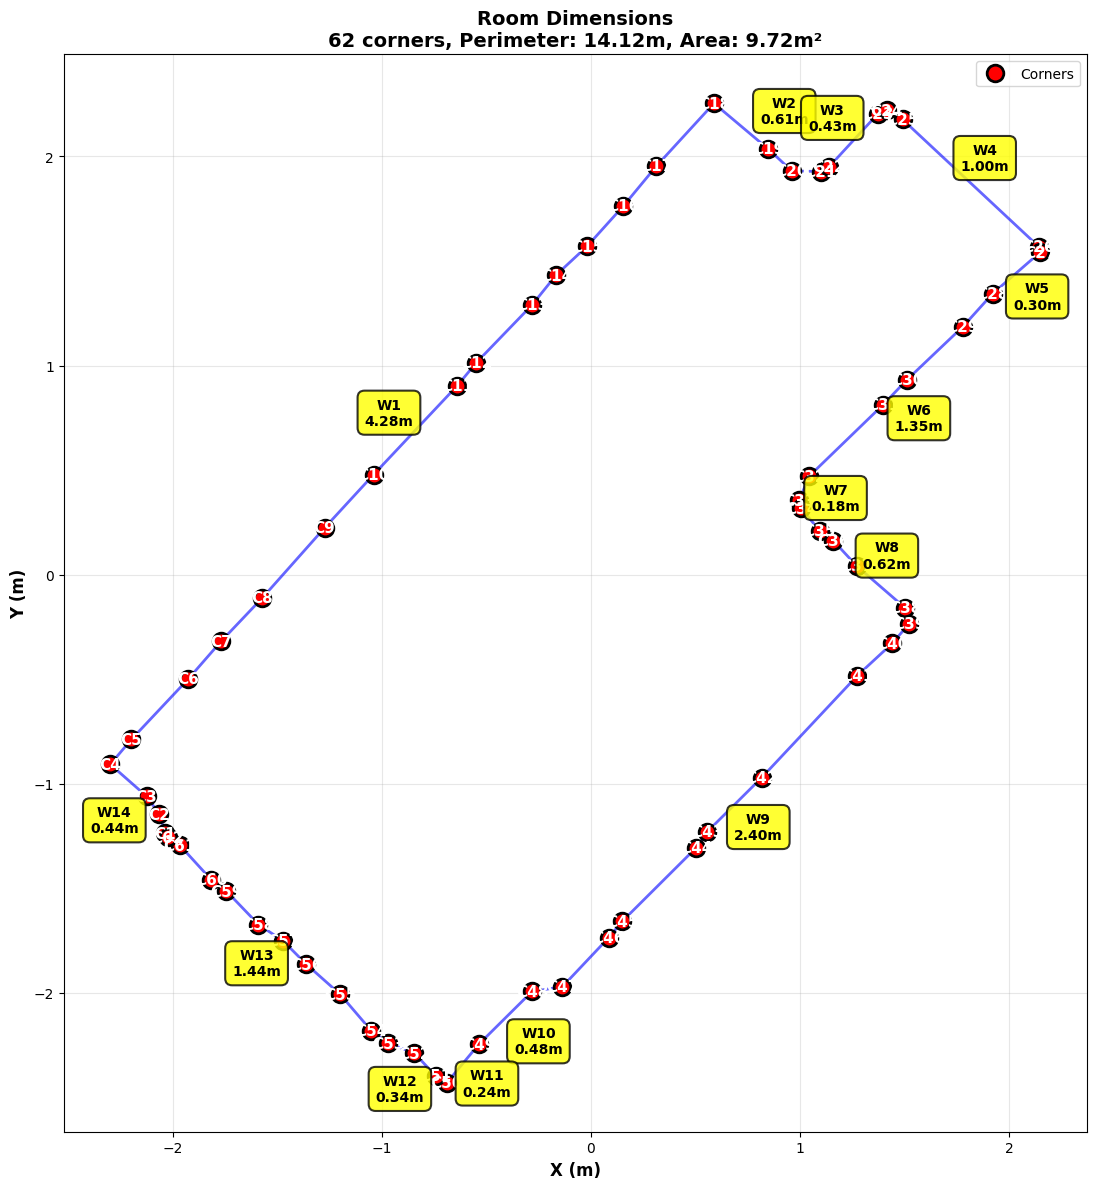

In [232]:
visualize_polygon_dimensions(simplified_points, merged_dimensions)

In [196]:
def extract_accurate_floorplan(wall_points, 
                               concave_ratio=0.05,
                               offset_distance=None,
                               merge_angle_tol=8.0,
                               merge_gap=0.15,
                               min_wall_length=0.30):
    """
    Optimized pipeline for accurate floorplan extraction
    NO simplification - just merging
    """
    
    # Step 1: Concave hull
    from shapely.geometry import MultiPoint
    import shapely
    
    multi_point = MultiPoint(wall_points[:, :2])
    boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
    
    # Step 2: Optional offset (if you computed wall thickness)
    if offset_distance:
        boundary = boundary.buffer(-offset_distance)
    
    # Step 3: Extract polygon points
    polygon_points = np.array(boundary.exterior.coords)[:-1]
    
    print(f"Boundary vertices: {len(polygon_points)}")
    
    # Step 4: Get initial dimensions
    dimensions = compute_polygon_dimensions(polygon_points)
    
    # Step 5: Merge (NO SIMPLIFICATION!)
    merged = merge_walls_complete(
        dimensions,
        angle_tolerance=merge_angle_tol,
        max_gap=merge_gap,
        min_wall_length=min_wall_length
    )
    
    return merged

In [201]:
final_walls = extract_accurate_floorplan(
    all_wall_points,
    concave_ratio=0.05,
    offset_distance=None
    merge_angle_tol=8.0,
    merge_gap=0.15,
    min_wall_length=0.30
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (646013276.py, line 4)

In [202]:
final_walls

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.5944672 , 2.25673579]),
  'length': np.float64(4.287500312248962),
  'angle': np.float64(47.55629362468778),
  'merged_from': [0, 1, 2],
  'num_segments': 3},
 {'wall_id': 2,
  'start_point': array([0.5944672 , 2.25673579]),
  'end_point': array([1.15673062, 1.97342183]),
  'length': np.float64(0.6296085675619869),
  'angle': np.float64(333.25732442882804)},
 {'wall_id': 3,
  'start_point': array([1.15673062, 1.97342183]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.3573468330965674),
  'angle': np.float64(44.097543625747484)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.15330142, 1.55253048]),
  'length': np.float64(0.9979104347267863),
  'angle': np.float64(317.85844245250485)},
 {'wall_id': 5,
  'start_point': array([2.15330142, 1.55253048]),
  'end_point': array([1.77863717, 1.18636316]),
  'length': np.float64(0.5238

In [203]:
def extract_merged_wall_polygon(merged_walls):
    """
    Extract polygon with only merged wall endpoints
    (Removes intermediate vertices but keeps real corners)
    
    Returns:
    --------
    corner_points : np.ndarray (N, 2)
        Just the corners (merged wall endpoints)
    """
    
    # Collect unique corners
    corners = []
    
    for wall in merged_walls:
        corners.append(wall['start_point'])
    
    # Close polygon (last wall's end = first wall's start)
    corners = np.array(corners)
    
    print(f"\nExtracted {len(corners)} corners from {len(merged_walls)} walls")
    
    return corners


def visualize_final_dimensions(merged_walls):
    """
    Clean visualization of final wall dimensions
    """
    import matplotlib.pyplot as plt
    
    # Extract corners
    corners = extract_merged_wall_polygon(merged_walls)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Draw polygon
    poly_closed = np.vstack([corners, corners[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1],
            'b-', linewidth=2, alpha=0.6)
    
    # Mark corners
    for i, corner in enumerate(corners):
        ax.plot(corner[0], corner[1], 'go', markersize=15,
                markeredgecolor='black', markeredgewidth=2)
        ax.text(corner[0], corner[1], f"C{i+1}",
                fontsize=11, fontweight='bold',
                ha='center', va='center', color='white')
    
    # Label walls with dimensions
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged_walls)))
    
    for i, wall in enumerate(merged_walls):
        # Draw wall line (thick)
        ax.plot([wall['start_point'][0], wall['end_point'][0]],
                [wall['start_point'][1], wall['end_point'][1]],
                '-', color=colors[i], linewidth=6, alpha=0.7)
        
        # Dimension label
        mid_x = (wall['start_point'][0] + wall['end_point'][0]) / 2
        mid_y = (wall['start_point'][1] + wall['end_point'][1]) / 2
        
        # Offset perpendicular
        vec = wall['end_point'] - wall['start_point']
        length = np.linalg.norm(vec)
        if length > 0:
            vec_norm = vec / length
            perp = np.array([-vec_norm[1], vec_norm[0]])
            offset = 0.20  # 20cm
            label_x = mid_x + perp[0] * offset
            label_y = mid_y + perp[1] * offset
        else:
            label_x, label_y = mid_x, mid_y
        
        ax.text(label_x, label_y,
                f"W{wall['wall_id']}\n{wall['length']:.2f}m",
                fontsize=12, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6',
                         facecolor='yellow', alpha=0.95,
                         edgecolor='black', linewidth=2))
    
    # Summary
    total_perim = sum(w['length'] for w in merged_walls)
    area = Polygon(corners).area
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=13, fontweight='bold')
    ax.set_title(f'Final Room Dimensions\n'
                f'{len(corners)} corners, {len(merged_walls)} walls\n'
                f'Perimeter: {total_perim:.2f}m, Area: {area:.2f}m²',
                fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


Extracted 11 corners from 11 walls


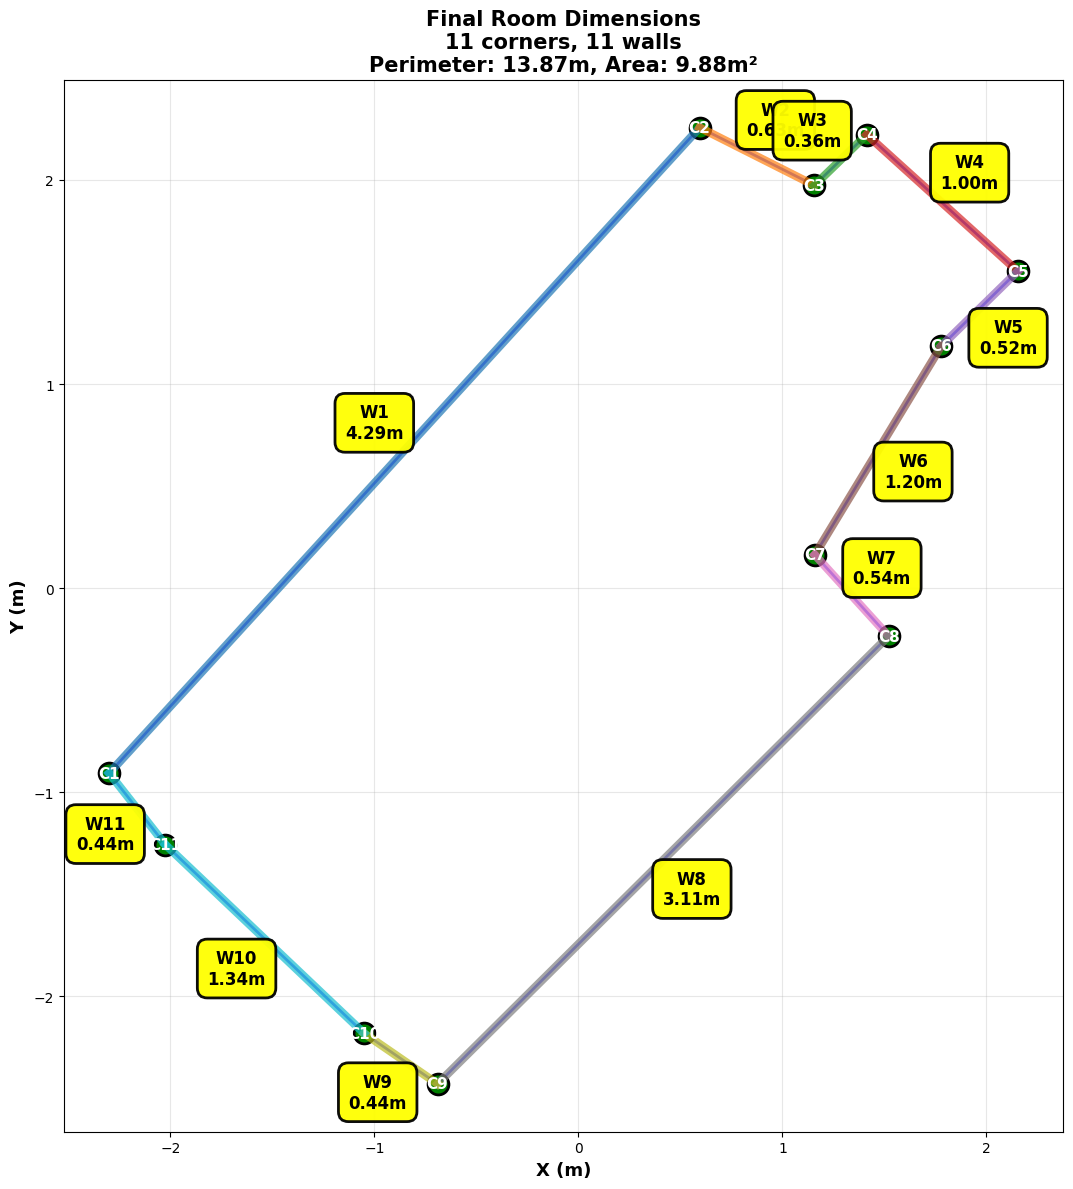

In [204]:
visualize_final_dimensions(final_walls)

In [74]:
import alphashape

In [75]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [77]:
hull = compute_concave_hull(wall_points_2d)


Computing concave hull with alpha=0.5...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 149
  Area: 12.33 m²
  Perimeter: 14.11 m


In [78]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

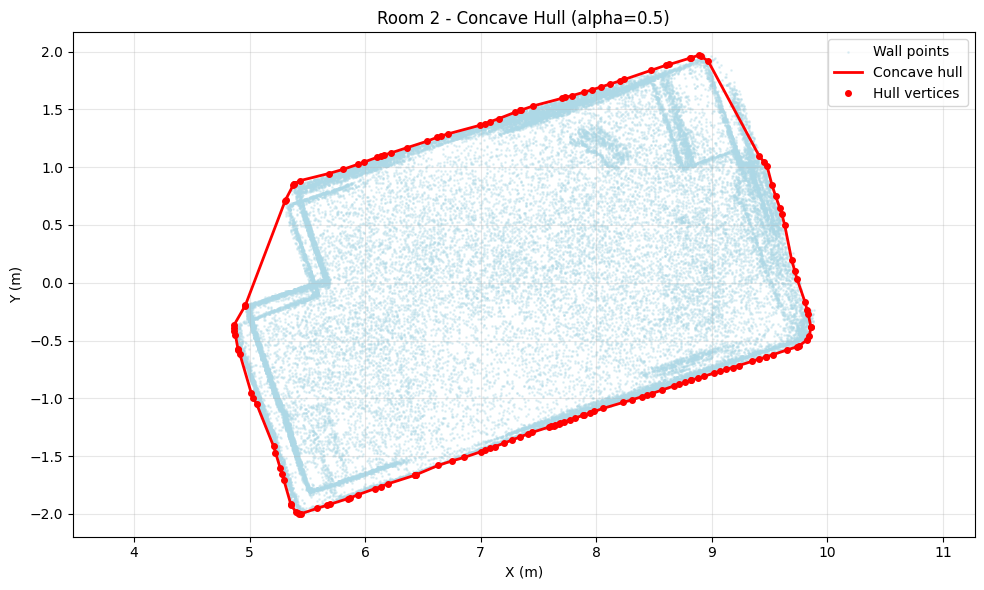


Visualization info:
  Plotted 42699 points (downsampled from 426989)
  Hull has 149 vertices


In [79]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [80]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.05...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 51
  Area: 12.42 m²
  Perimeter: 14.10 m


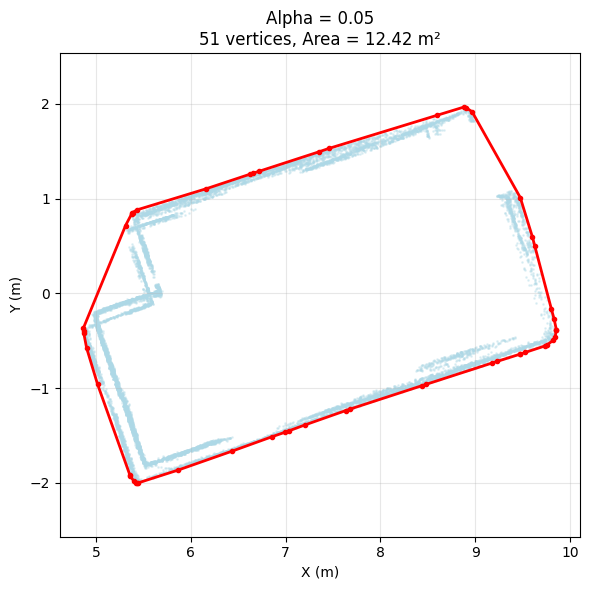

In [83]:
compare_alpha_values(wall_points_2d, alpha_values=[0.05])

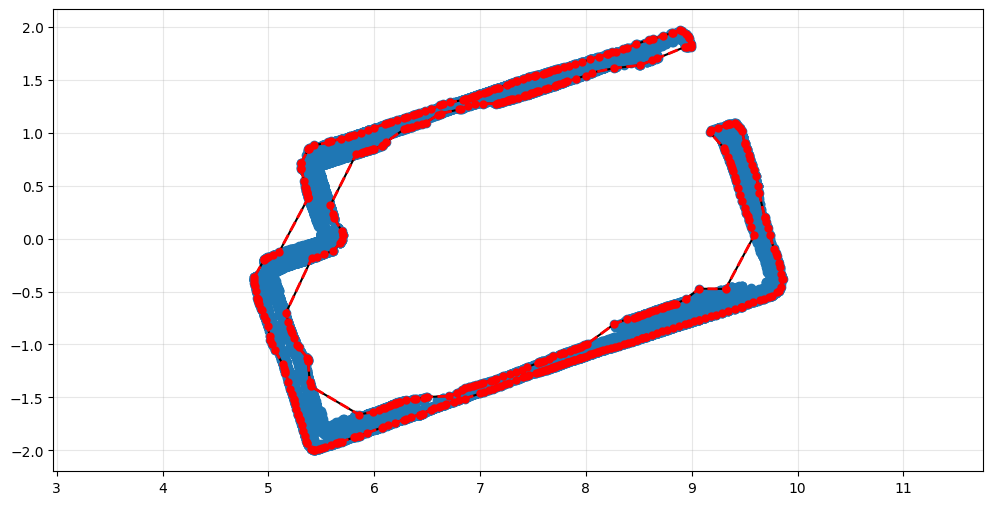

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(wall_points_2d, alpha=0.4)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [85]:
voxel_down_pcd = sem_seg.pcd

In [ ]:
(voxel_down_pcd.select_by_index(ind))

PointCloud with 410042 points.

In [91]:
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


In [94]:
o3d.visualization.draw_geometries([cl])

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

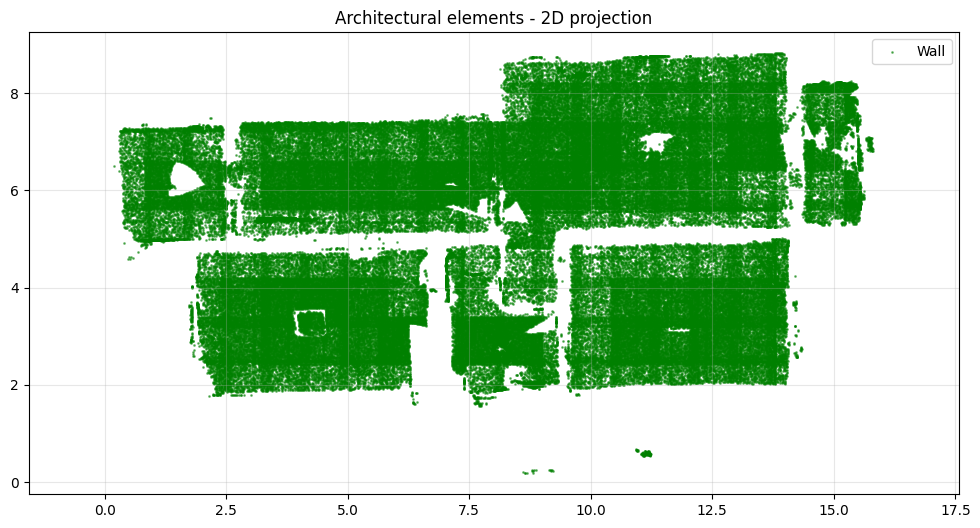

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

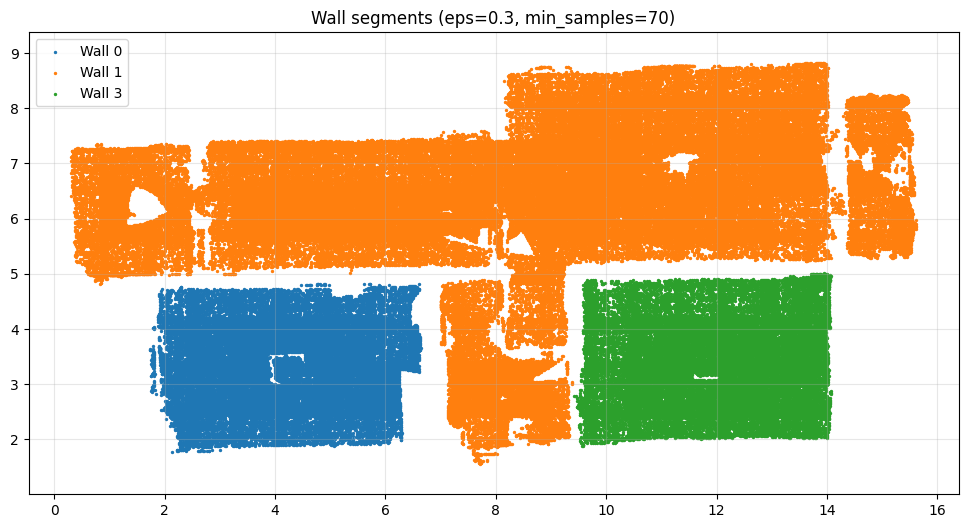

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

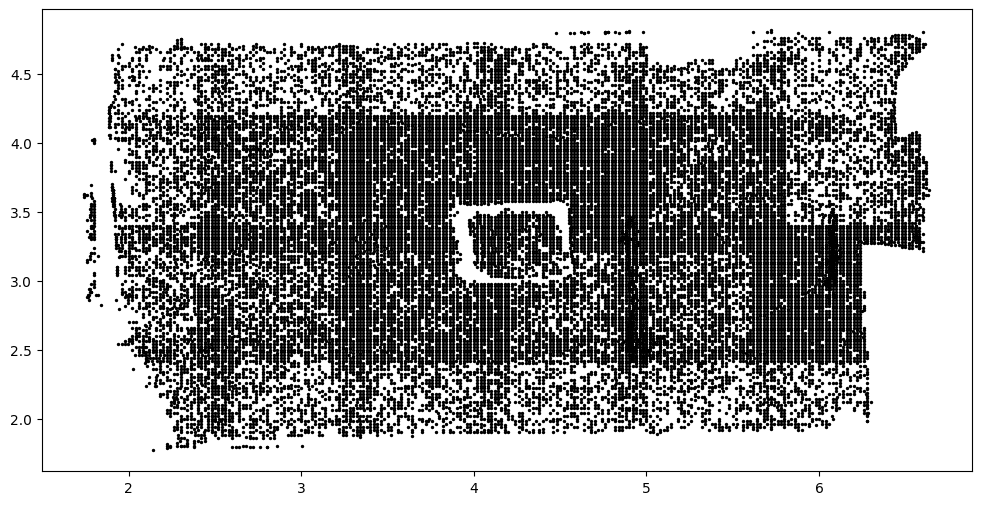

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


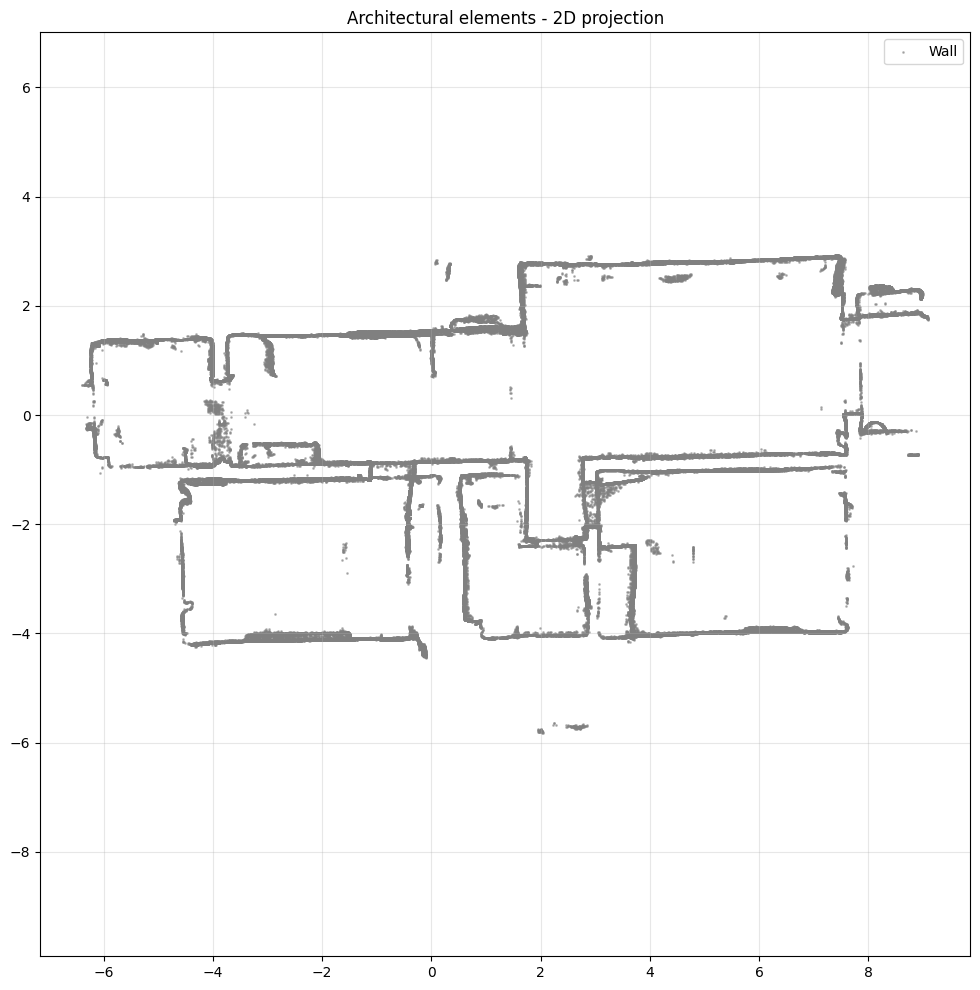

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

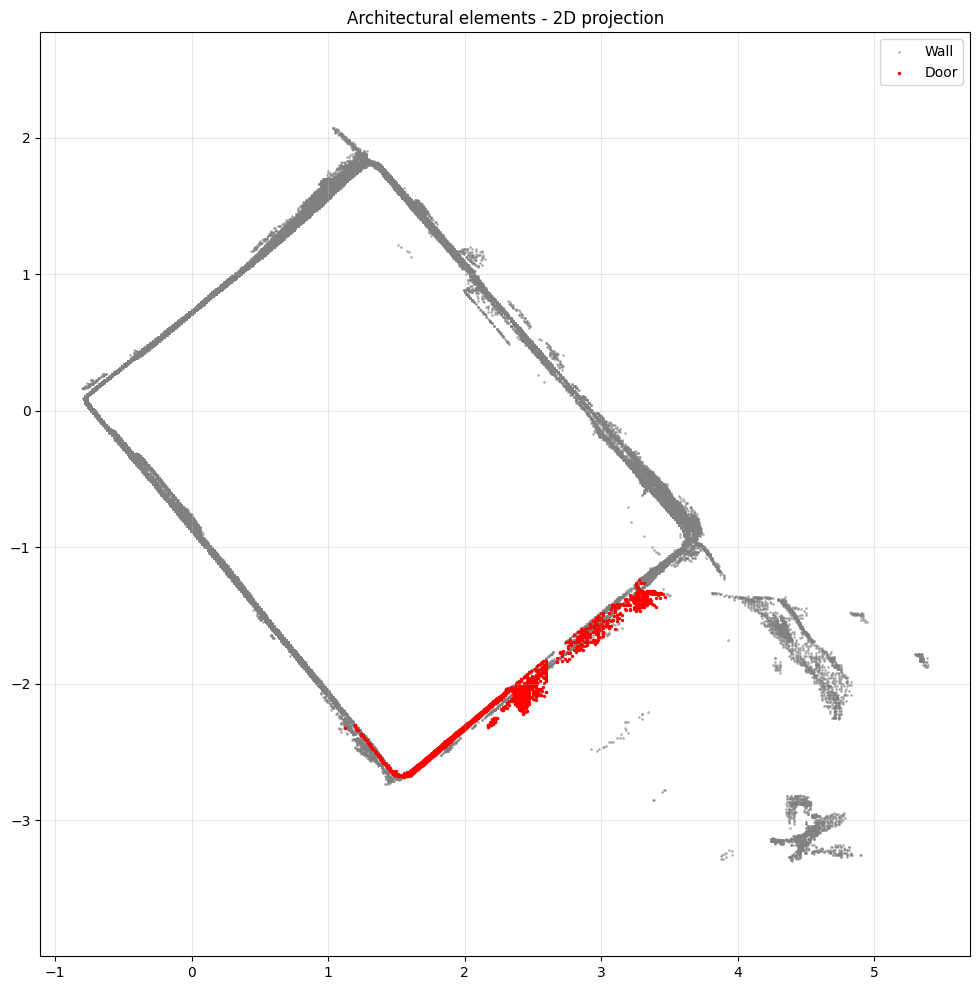

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()